In [1]:
%load_ext Cython
import numpy as np
ň = np.newaxis
from scipy.constants import epsilon_0 as ε_0, c, pi as π, e, hbar as ℏ, mu_0 as μ_0
eV = e
from scipy.special import lpmn, lpmv, sph_jn, sph_yn, poch
from scipy.misc import factorial
import math
import cmath

In [2]:
%%cython
# cythonized functions here
cimport numpy as np
import numpy as np
cimport cython

## Auxillary function for retrieving the "meshgrid-like" indices; inc. nmax
@cython.boundscheck(False)
def get_mn_y(int nmax):
    """
    Auxillary function for retreiving the 'meshgrid-like' indices from the flat indexing; 
    inc. nmax.
    ('y to mn' conversion)
    
    Parameters
    ----------

    nmax : int
        The maximum order to which the VSWFs / Legendre functions etc. will be evaluated.
        
    Returns
    -------
    
    output : (m, n)
        Tuple of two arrays of type np.array(shape=(nmax*nmax + 2*nmax), dtype=np.int),
        where [(m[y],n[y]) for y in range(nmax*nmax + 2*nma)] covers all possible 
        integer pairs n >= 1, -n <= m <= n.
    """
    cdef Py_ssize_t nelems = nmax * nmax + 2 * nmax
    cdef np.ndarray[np.int_t,ndim=1] m_arr = np.empty([nelems], dtype=np.int)
    cdef np.ndarray[np.int_t,ndim=1] n_arr = np.empty([nelems], dtype=np.int)
    cdef Py_ssize_t i = 0
    cdef np.int_t n, m
    for n in range(1,nmax+1):
        for m in range(-n,n+1):
            m_arr[i] = m
            n_arr[i] = n
            i = i + 1
    return (m_arr, n_arr)

def get_y_mn_unsigned(int nmax): 
    """
    Auxillary function for mapping 'unsigned m', n indices to the flat y-indexing.
    For use with functions as scipy.special.lpmn, which have to be evaluated separately
    for positive and negative m.
    
    Parameters
    ----------

    nmax : int
        The maximum order to which the VSWFs / Legendre functions etc. will be evaluated.
        
    output : (ymn_plus, ymn_minus)
        Tuple of two arrays of shape (nmax+1,nmax+1), containing the flat y-indices corresponding
        to the respective (m,n) and (-m,n). The elements for which |m| > n are set to -1.
        (Therefore, the caller must not use those elements equal to -1.)
    """
    cdef np.ndarray[np.intp_t, ndim=2] ymn_plus = np.full((nmax+1,nmax+1),-1, dtype=np.intp)
    cdef np.ndarray[np.intp_t, ndim=2] ymn_minus = np.full((nmax+1,nmax+1),-1, dtype=np.intp)
    cdef Py_ssize_t i = 0
    cdef np.int_t n, m
    for n in range(1,nmax+1):
        for m in range(-n,0):
            ymn_minus[-m,n] = i
            i = i + 1
        for m in range(0,n+1):
            ymn_plus[m,n] = i
            i = i + 1
    return(ymn_plus, ymn_minus)

In [3]:
# Coordinate transforms for arrays of "arbitrary" shape
def cart2sph(cart,axis=-1):
    if (cart.shape[axis] != 3):
        raise ValueError("The converted array has to have dimension 3"
                         " along the given axis")
    [x, y, z] = np.split(cart,3,axis=axis)
    r = np.linalg.norm(cart,axis=axis,keepdims=True)
    r_zero = np.logical_not(r)
    θ = np.arccos(z/(r+r_zero))
    φ = np.arctan2(y,x) # arctan2 handles zeroes correctly itself
    return np.concatenate((r,θ,φ),axis=axis)

def sph2cart(sph, axis=-1):
    if (sph.shape[axis] != 3):
        raise ValueError("The converted array has to have dimension 3"
                         " along the given axis")
    [r,θ,φ] = np.split(sph,3,axis=axis)
    sinθ = np.sin(θ)
    x = r * sinθ * np.cos(φ)
    y = r * sinθ * np.sin(φ)
    z = r * np.cos(θ)
    return np.concatenate((x,y,z),axis=axis)

def sph_loccart2cart(loccart, sph, axis=-1):
    """
    Transformation of vector specified in local orthogonal coordinates 
    (tangential to spherical coordinates – basis r̂,θ̂,φ̂) to global cartesian
    coordinates (basis x̂,ŷ,ẑ)
    SLOW FOR SMALL ARRAYS
    
    Parameters
    ----------
    loccart: ... TODO
        the transformed vector in the local orthogonal coordinates
        
    sph: ... TODO
        the point (in spherical coordinates) at which the locally
        orthogonal basis is evaluated
        
    Returns
    -------
    output: ... TODO
        The coordinates of the vector in global cartesian coordinates
    """
    if (loccart.shape[axis] != 3):
        raise ValueError("The converted array has to have dimension 3"
                         " along the given axis")
    [r,θ,φ] = np.split(sph,3,axis=axis)
    sinθ = np.sin(θ)
    cosθ = np.cos(θ)
    sinφ = np.sin(φ)
    cosφ = np.cos(φ)
    
    #x = r * sinθ * cosφ
    #y = r * sinθ * sinφ
    #z = r * cosθ
    r̂x = sinθ * cosφ
    r̂y = sinθ * sinφ
    r̂z = cosθ
    θ̂x = cosθ * cosφ
    θ̂y = cosθ * sinφ
    θ̂z = -sinθ
    φ̂x = -sinφ
    φ̂y = cosφ
    φ̂z = np.zeros(φ̂y.shape)
    r̂ = np.concatenate((r̂x,r̂y,r̂z),axis=axis)
    θ̂ = np.concatenate((θ̂x,θ̂y,θ̂z),axis=axis)
    φ̂ = np.concatenate((φ̂x,φ̂y,φ̂z),axis=axis)
    [inr̂,inθ̂,inφ̂] = np.split(loccart,3,axis=axis)
    out=inr̂*r̂+inθ̂*θ̂+inφ̂*φ̂
    return out


def lpy(nmax, z):
    """
    Associated legendre function and its derivatative at z in the 'y-indexing'.
    (Without Condon-Shortley phase AFAIK.)
    NOT THOROUGHLY TESTED
    
    Parameters
    ----------
    
    nmax: int
        The maximum order to which the Legendre functions will be evaluated..
        
    z: float
        The point at which the Legendre functions are evaluated.
        
    output: (P_y, dP_y) TODO
        y-indexed legendre polynomials and their derivatives
    
    """
    pmn_plus, dpmn_plus = lpmn(nmax, nmax, z)
    pmn_minus, dpmn_minus = lpmn(-nmax, nmax, z)
    nelem = nmax * nmax + 2*nmax
    P_y = np.empty((nelem), dtype=np.float_)
    dP_y = np.empty((nelem), dtype=np.float_)
    mn_p_y, mn_n_y = get_y_mn_unsigned(nmax)
    mn_plus_mask = (mn_p_y >= 0)
    mn_minus_mask = (mn_n_y >= 0)
    #print( mn_n_y[mn_minus_mask])
    P_y[mn_p_y[mn_plus_mask]] = pmn_plus[mn_plus_mask]
    P_y[mn_n_y[mn_minus_mask]] = pmn_minus[mn_minus_mask]
    dP_y[mn_p_y[mn_plus_mask]] = dpmn_plus[mn_plus_mask]
    dP_y[mn_n_y[mn_minus_mask]] = dpmn_minus[mn_minus_mask]
    return (P_y, dP_y)

def vswf_yr(pos_sph,nmax,J=1):
    """
    Normalized vector spherical wavefunctions $\widetilde{M}_{mn}^{j}$,
    $\widetilde{N}_{mn}^{j}$ as in [1, (2.40)].
    
    Parameters
    ----------
    
    pos_sph : np.array(dtype=float, shape=(someshape,3))
        The positions where the spherical vector waves are to be
        evaluated. The last axis corresponds to the individual
        points (r,θ,φ). The radial coordinate r is dimensionless,
        assuming that it has already been multiplied by the
        wavenumber.
    
    nmax : int
        The maximum order to which the VSWFs are evaluated.
        
    Returns
    -------
    
    output : np.array(dtype=complex, shape=(someshape,nmax*nmax + 2*nmax,3))
        Spherical vector wave functions evaluated at pos_sph,
        in the local basis (r̂,θ̂,φ̂). The last indices correspond
        to m, n (in the ordering given by mnindex()), and basis 
        vector index, respectively.
        
    [1] Jonathan M. Taylor. Optical Binding Phenomena: Observations and
    Mechanisms.
    """
    #mi, ni = mnindex(nmax)
    #nelems = nmax*nmax + 2*nmax
    ## TODO Remove these two lines in production:
    #if(len(mi) != nelems):
    #    raise ValueError("This is very wrong.")
    ## Pre-calculate the associated Legendre function
    #Prmn, dPrmn = lpmn(nmax,nmax,)
    ## Normalized funs π̃, τ̃
    #π̃ = 
    pass

from scipy.special import sph_jn, sph_yn
def _sph_zn_1(n,z):
    return sph_jn(n,z)
def _sph_zn_2(n,z):
    return sph_yn(n,z)
def _sph_zn_3(n,z):
    besj=sph_jn(n,z)
    besy=sph_yn(n,z)
    return (besj[0] + 1j*besy[0],besj[1] + 1j*besy[1])
def _sph_zn_4(n,z):
    besj=sph_jn(n,z)
    besy=sph_yn(n,z)
    return (besj[0] - 1j*besy[0],besj[1] - 1j*besy[1])
_sph_zn = [_sph_zn_1,_sph_zn_2,_sph_zn_3,_sph_zn_4]

# computes bessel/hankel functions for orders from 0 up to n; drops
# the derivatives which are also included in scipy.special.sph_jn/yn
def zJn(n, z, J=1):
    return _sph_zn[J-1](n=n,z=z)



# The following 4 funs have to be refactored, possibly merged
def π̃_zerolim(nmax): # seems OK
    """
    lim_{θ→ 0-} π̃(cos θ)
    """
    my, ny = get_mn_y(nmax)
    nelems = len(my)
    π̃_y = np.zeros((nelems))
    plus1mmask = (my == 1)
    minus1mmask = (my == -1)
    pluslim = -ny*(1+ny)/2
    minuslim = 0.5
    π̃_y[plus1mmask] = pluslim[plus1mmask]
    π̃_y[minus1mmask] = - minuslim
    prenorm =  np.sqrt((2*ny + 1)*factorial(ny-my)/(4*π*factorial(ny+my)))
    π̃_y = prenorm *     π̃_y
    return π̃_y

def π̃_pilim(nmax): # Taky OK, jen to možná není kompatibilní se vzorečky z mathematiky
    """
    lim_{θ→ π+} π̃(cos θ)
    """
    my, ny = get_mn_y(nmax)
    nelems = len(my)
    π̃_y = np.zeros((nelems))
    plus1mmask = (my == 1)
    minus1mmask = (my == -1)
    pluslim = (-1)**ny*ny*(1+ny)/2
    minuslim = 0.5*(-1)**ny
    π̃_y[plus1mmask] = pluslim[plus1mmask]
    π̃_y[minus1mmask] = minuslim[minus1mmask]
    prenorm =  np.sqrt((2*ny + 1)*factorial(ny-my)/(4*π*factorial(ny+my)))
    π̃_y = prenorm *     π̃_y
    return π̃_y

def τ̃_zerolim(nmax):
    """
    lim_{θ→ 0-} τ̃(cos θ)
    """
    p0 = π̃_zerolim(nmax)
    my, ny = get_mn_y(nmax)
    minus1mmask = (my == -1)
    p0[minus1mmask] = -p0[minus1mmask]
    return p0

def τ̃_pilim(nmax):
    """
    lim_{θ→  π+} τ̃(cos θ)
    """
    t = π̃_pilim(nmax)
    my, ny = get_mn_y(nmax)
    plus1mmask = (my == 1)
    t[plus1mmask] = -t[plus1mmask]
    return t
    
def get_π̃τ̃_y1(θ,nmax):
    # TODO replace with the limit functions (below) when θ approaches
    # the extreme values at about 1e-6 distance
    """
    (... TODO)
    
    """
    if (abs(θ)<1e-6):
        return (π̃_zerolim(nmax),τ̃_zerolim(nmax))
    if (abs(θ-π)<1e-6):
        return (π̃_pilim(nmax),τ̃_pilim(nmax))
    my, ny = get_mn_y(nmax)
    nelems = len(my)
    Py, dPy = lpy(nmax, math.cos(θ))
    prenorm =  np.sqrt((2*ny + 1)*factorial(ny-my)/(4*π*factorial(ny+my)))
    π̃_y = prenorm * my * Py / math.sin(θ)  # bacha, možné dělení nulou
    τ̃_y = prenorm * dPy * (- math.sin(θ))  # TADY BACHA!!!!!!!!!! * (- math.sin(pos_sph[1])) ???
    return (π̃_y,τ̃_y)
    
def vswf_yr1(pos_sph,nmax,J=1):
    """
    As vswf_yr, but evaluated only at single position (i.e. pos_sph has
    to have shape=(3))
    """
    if (pos_sph[1].imag or pos_sph[2].imag):
        raise ValueError("The angles for the spherical wave functions can not be complex")
    kr = pos_sph[0] if pos_sph[0].imag else pos_sph[0].real # To supress the idiotic warning in scipy.special.sph_jn
    θ = pos_sph[1].real
    φ = pos_sph[2].real
    my, ny = get_mn_y(nmax)
    Py, dPy = lpy(nmax, math.cos(θ))
    nelems = nmax*nmax + 2*nmax
    # TODO Remove these two lines in production:
    if(len(Py) != nelems or len(my) != nelems):
        raise ValueError("This is very wrong.")
    prenorm =  np.sqrt((2*ny + 1)*factorial(ny-my)/(4*π*factorial(ny+my)))
    if (abs(θ)<1e-6): # Ošetření limitního chování derivací Leg. fcí
        π̃_y=π̃_zerolim(nmax)
        τ̃_y=τ̃_zerolim(nmax)
    elif (abs(θ-π)<1e-6):
        π̃_y=π̃_pilim(nmax)
        τ̃_y=τ̃_pilim(nmax)
    else:
        π̃_y = prenorm * my * Py / math.sin(θ) 
        τ̃_y = prenorm * dPy * (- math.sin(θ))  # TADY BACHA!!!!!!!!!! * (- math.sin(pos_sph[1])) ???
    z_n, dz_n = zJn(nmax, kr, J=J)
    z_y = z_n[ny]
    dz_y = dz_n[ny]
    eimf_y = np.exp(1j*my*φ) # zbytečné opakování my, lepší by bylo to spočítat jednou a vyindexovat
    M̃_y = np.zeros((nelems,3), dtype=np.complex_)
    M̃_y[:,1] = 1j * π̃_y * eimf_y * z_y
    M̃_y[:,2] =  -   τ̃_y * eimf_y * z_y
    Ñ_y = np.empty((nelems,3), dtype=np.complex_)
    Ñ_y[:,0] = (ny*(ny+1)/kr) * prenorm * Py * eimf_y * z_y
    Ñradial_fac_y = z_y / kr + dz_y
    Ñ_y[:,1] =    τ̃_y * eimf_y * Ñradial_fac_y
    Ñ_y[:,2] = 1j*π̃_y * eimf_y * Ñradial_fac_y
    return(M̃_y, Ñ_y)
    
#def plane_E_y(nmax):
#    """
#    The E_mn normalization factor as in [1, (3)] WITHOUT the E_0 factor,
#    y-indexed
#    
#    (... TODO)
#    
#    References
#    ----------
#    [1] Jonathan M. Taylor. Optical Binding Phenomena: Observations and
#    Mechanisms. FUCK, I MADE A MISTAKE: THIS IS FROM 7U
#    """
#    my, ny = get_mn_y(nmax)
#    return 1j**ny * np.sqrt((2*ny+1)*factorial(ny-my) /
#                            (ny*(ny+1)*factorial(ny+my))
#    )

def zplane_pq_y(nmax, betap = 0):
    """
    The z-propagating plane wave expansion coefficients as in [1, (1.12)]
    
    (... TODO)
    """
    my, ny = get_mn_y(nmax)
    U_y = 4*π * 1j**ny / (ny * (ny+1))
    π̃_y = π̃_zerolim(nmax)
    τ̃_y = τ̃_zerolim(nmax)
    
    # fixme co je zač ten e_θ ve vzorečku? (zde neimplementováno)
    p_y = U_y*(τ̃_y*math.cos(betap) - 1j*math.sin(betap)*π̃_y)
    q_y = U_y*(π̃_y*math.cos(betap) - 1j*math.sin(betap)*τ̃_y)
    return (p_y, q_y)
    
    
import warnings
def plane_pq_y(nmax, kdir_cart, E_cart):
    """
    The plane wave expansion coefficients for any direction kdir_cart
    and amplitude vector E_cart (which might be complex, depending on
    the phase and polarisation state). If E_cart and kdir_cart are
    not orthogonal, the result should correspond to the k-normal part
    of E_cart.
    """
    if np.iscomplexobj(kdir_cart):
        warnings.warn("The direction vector for the plane wave coefficients should be real. I am discarding the imaginary part now.")
        kdir_cart = kdir_cart.real
        
    k_sph = cart2sph(kdir_cart)
    π̃_y, τ̃_y = get_π̃τ̃_y1(k_sph[1], nmax) 
    my, ny = get_mn_y(nmax)
    U_y = 4*π * 1j**ny / (ny * (ny+1))
    θ̂ = sph_loccart2cart(np.array([0,1,0]), k_sph, axis=-1)
    φ̂ = sph_loccart2cart(np.array([0,0,1]), k_sph, axis=-1)
    p_y = np.sum( U_y[:,ň]
                  * np.conj(np.exp(1j*my[:,ň]*k_sph[2]) * (
                     θ̂[ň,:]*τ̃_y[:,ň] + 1j*φ̂[ň,:]*π̃_y[:,ň]))
                  * E_cart[ň,:],
              axis=-1)
    q_y = np.sum( U_y[:,ň]
                  * np.conj(np.exp(1j*my[:,ň]*k_sph[2]) * (
                     θ̂[ň,:]*π̃_y[:,ň] + 1j*φ̂[ň,:]*τ̃_y[:,ň]))
                  * E_cart[ň,:],
          axis=-1)
    return (p_y, q_y)
    

In [4]:
# Functions copied from scattering_xu, additionaly normalized
from py_gmm.gmm import vec_trans as vc

def q_max(m,n,μ,ν):
    return min(n,ν,(n+ν-abs(m+μ))/2)
    
# returns array with indices corresponding to q
# argument q does nothing for now
def a_q(m,n,μ,ν,q = None):
    qm=q_max(m,n,μ,ν)
    res, err= vc.gaunt_xu(m,n,μ,ν,qm)
    if(err):
        print("m,n,μ,ν,qm = ",m,n,μ,ν,qm)
        raise ValueError('Something bad in the fortran subroutine gaunt_xu happened')
    return res

# All arguments are single numbers (for now)
# ZDE VYCHÁZEJÍ DIVNÁ ZNAMÉNKA
def Ã(m,n,μ,ν,kdlj,θlj,φlj,r_ge_d,J):
    exponent=(math.lgamma(2*n+1)-math.lgamma(n+2)+math.lgamma(2*ν+3)-math.lgamma(ν+2) 
                +math.lgamma(n+ν+m-μ+1)-math.lgamma(n-m+1)-math.lgamma(ν+μ+1)
                +math.lgamma(n+ν+1) - math.lgamma(2*(n+ν)+1))
    presum = math.exp(exponent)
    presum = presum * np.exp(1j*(μ-m)*φlj) * (-1)**m * 1j**(ν+n) / (4*n)
    qmax = math.floor(q_max(-m,n,μ,ν)) #nemá tu být +m?
    q = np.arange(qmax+1, dtype=int)
    # N.B. -m !!!!!!
    a1q = a_q(-m,n,μ,ν) # there is redundant calc. of qmax
    ã1q = a1q / a1q[0]
    p = n+ν-2*q
    if(r_ge_d):
        J = 1
    zp = zJn(n+ν,kdlj,J)[0][p]
    Pp = lpmv(μ-m,p,math.cos(θlj))
    summandq = (n*(n+1) + ν*(ν+1) - p*(p+1)) * (-1)**q * ã1q * zp * Pp
  
    # Taylor normalisation v2, proven to be equivalent (NS which is better)
    prenormratio = 1j**(ν-n) * math.sqrt(((2*ν+1)/(2*n+1))* math.exp(
        math.lgamma(n+m+1)-math.lgamma(n-m+1)+math.lgamma(ν-μ+1)-math.lgamma(ν+μ+1)))
    presum = presum / prenormratio
    
    # Taylor normalisation
    #prenormmn =  math.sqrt((2*n + 1)*math.factorial(n-m)/(4*π*factorial(n+m)))
    #prenormμν =  math.sqrt((2*ν + 1)*math.factorial(ν-μ)/(4*π*factorial(ν+μ)))
    #presum = presum * prenormμν / prenormmn
    
    return presum * np.sum(summandq)
    
# ZDE OPĚT JINAK ZNAMÉNKA než v Xu (J. comp. phys 127, 285)
def B̃(m,n,μ,ν,kdlj,θlj,φlj,r_ge_d,J):
    exponent=(math.lgamma(2*n+3)-math.lgamma(n+2)+math.lgamma(2*ν+3)-math.lgamma(ν+2) 
                +math.lgamma(n+ν+m-μ+2)-math.lgamma(n-m+1)-math.lgamma(ν+μ+1)
                +math.lgamma(n+ν+2) - math.lgamma(2*(n+ν)+3))
    presum = math.exp(exponent)
    presum = presum * np.exp(1j*(μ-m)*φlj) * (-1)**m * 1j**(ν+n+1) / (
        (4*n)*(n+1)*(n+m+1))
    Qmax = math.floor(q_max(-m,n+1,μ,ν))
    q = np.arange(Qmax+1, dtype=int)
    if (μ == ν): # it would disappear in the sum because of the factor (ν-μ) anyway
        ã2q = 0
    else:
        a2q = a_q(-m-1,n+1,μ+1,ν)
        ã2q = a2q / a2q[0]
    a3q = a_q(-m,n+1,μ,ν)
    ã3q = a3q / a3q[0]
    p = n+ν-2*q
    if(r_ge_d):
        J = 1
    zp_ = zJn(n+1+ν,kdlj,J)[0][p+1] # je ta +1 správně?
    Pp_ = lpmv(μ-m,p+1,math.cos(θlj))
    summandq = ((2*(n+1)*(ν-μ)*ã2q
                 -(-ν*(ν+1) - n*(n+3) - 2*μ*(n+1)+p*(p+3))* ã3q)
                *(-1)**q * zp_ * Pp_)
    
    # Taylor normalisation v2, proven to be equivalent
    prenormratio = 1j**(ν-n) * math.sqrt(((2*ν+1)/(2*n+1))* math.exp(
        math.lgamma(n+m+1)-math.lgamma(n-m+1)+math.lgamma(ν-μ+1)-math.lgamma(ν+μ+1)))
    presum = presum / prenormratio
    
    ## Taylor normalisation
    #prenormmn =  math.sqrt((2*n + 1)*math.factorial(n-m)/(4*π*factorial(n+m)))
    #prenormμν =  math.sqrt((2*ν + 1)*math.factorial(ν-μ)/(4*π*factorial(ν+μ)))
    #presum = presum * prenormμν / prenormmn
    
    return presum * np.sum(summandq)
 

In [5]:
# Mie scattering
def mie_coefficients(a, nmax,  ω, ε_i, ε_e=1, μ_i=1, μ_e=1, J_ext=1, J_scat=3
                               ):
    """
    FIXME: THIS IS A DIRTY COPY&PASTE. CLEAN THE CODE!
    FIXME: The results might be wrong!!!!
    TODO description
    #
    
    Parameters
    ----------
    a : float
        Diameter of the sphere.
        
    nmax : int
        To which order (inc. nmax) to compute the coefficients.
    
    ω : float
        Frequency of the radiation
    
    ε_i, ε_e, μ_i, μ_e : complex
        Relative permittivities and permeabilities of the sphere (_i)
        and the environment (_e)
    
    J_ext, J_scat : 1, 2, 3, or 4 (must be different)
        Specifies the species of the Bessel/Hankel functions in which
        the external incoming (J_ext) and scattered (J_scat) fields
        are represented. 1,2,3,4 correspond to j,y,h(1),h(2), respectively.
        The returned coefficients are always with respect to the decomposition
        of the "external incoming" wave.
    
    Returns
    -------
    TODO
    """
    # permittivities are relative!
    # cf. worknotes
    #print("a, nmax, ε_m, ε_b, ω",a, nmax, ε_m, ε_b, ω)
    k_i = cmath.sqrt(ε_i*μ_i) * ω / c
    x_i = k_i * a
    k_e = cmath.sqrt(ε_e*μ_e) * ω / c
    x_e = k_e * a
    print("x_i",x_i,"x_e",x_e)
    m = cmath.sqrt(ε_i*μ_i/(ε_e*μ_e))
    # We "need" the absolute permeabilities for the final formula
    μ_i = μ_i * μ_0
    μ_e = μ_e * μ_0
    #print("k_m, x_m,k_b,x_b",k_m, x_m,k_b,x_b)
    zi, ži = zJn(nmax, x_i, J=1)
    ži = zi + x_i * ži
    ze, že = zJn(nmax, x_e, J=J_ext)
    že = ze + x_e * že
    zs, žs = zJn(nmax, x_e, J=J_scat)
    žs = zs + x_e * zs
    RH = (μ_i*zi*že - μ_e*ze*ži) / (μ_i*zi*žs - μ_e*zs*ži)
    RV = (μ_e*m*m*zi*že - μ_i*ze*ži) / (μ_e*m*m*zi*žs - μ_i*zs*ži)
    TH = (μ_i*ze*žs - μ_i*zs*že) / (μ_i*zi*žs - μ_e*zs*ži)
    TV = (μ_i*m*ze*žs - μ_i*m*zs*že) / (μ_e*m*m*zi*žs - μ_i*zs*ži)
    return (RH, RV, TH, TV)

TODOs
====

Rewrite the functions zJn, lpy in (at least simulated) universal manner.
Then universalise the rest

Implement the actual multiple scattering


In [6]:
#import traceback
#import warnings
#import sys

#def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
#    traceback.print_stack()
#    log = file if hasattr(file,'write') else sys.stderr
#    log.write(warnings.formatwarning(message, category, filename, lineno, line))

#warnings.showwarning = warn_with_traceback

# Test Mieho rozptylu vs kvasistatické (dipólové) approximace malé koule
#import warnings
#warnings.filterwarnings('error')
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

scalefactor =1#ℏ/eV # fuck matplotlib...

nmax = 20
J_ext = 1
J_scat = 3
ω = 4*eV/ℏ *scalefactor
ε_in = 1.3
ε_out = 1.3
R = 1e-8 / scalefactor
k_in = ω*math.sqrt(ε_in)/c
k_out = ω*cmath.sqrt(ε_out)/c
k_cart = k_out * np.array([1,0,0]) 
E⃗_0 = np.array([0,0,1])

h2 = 1.5*R
w2 = 1.4*R
z = np.linspace(-h2,h2,32)
y = np.linspace(-w2,w2,31)
#y = [0]
#x,y,z = np.meshgrid(x,y,z)
x, z = np.meshgrid(y,z)
y = x*0.0

# Souřadnice a původní vlna
my, ny = get_mn_y(nmax)
nelem = len(my)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)

E_plane = E⃗_0[np.newaxis,:] * np.exp(1j*np.sum(k_cart[ň,:]*cartgrid,axis=-1))[:,np.newaxis]


p_y, q_y = plane_pq_y(nmax, k_cart, E⃗_0)



M_sph_ry_in = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_in = np.zeros((len(x),nelem,3),dtype=np.complex_)
M_sph_ry_scat = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_scat = np.zeros((len(x),nelem,3),dtype=np.complex_)
M_sph_ry_ext = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_ext = np.zeros((len(x),nelem,3),dtype=np.complex_)

for ri in range(len(x)):
    if (sphgrid[ri,0] < R):
        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_in,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=1)
        M_sph_ry_in[ri] = M
        N_sph_ry_in[ri] = N
    else:
        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_out,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=J_scat)
        M_sph_ry_scat[ri] = M
        N_sph_ry_scat[ri] = N
        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_out,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=J_ext)
        M_sph_ry_ext[ri] = M
        N_sph_ry_ext[ri] = N
    
M_cart_ry_ext = sph_loccart2cart(M_sph_ry_ext, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_ext = sph_loccart2cart(N_sph_ry_ext, sphgrid[:,np.newaxis,:], axis=-1)
M_cart_ry_scat = sph_loccart2cart(M_sph_ry_scat, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_scat = sph_loccart2cart(N_sph_ry_scat, sphgrid[:,np.newaxis,:], axis=-1)
M_cart_ry_in = sph_loccart2cart(M_sph_ry_in, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_in = sph_loccart2cart(N_sph_ry_in, sphgrid[:,np.newaxis,:], axis=-1)


RH, RV, TH, TV = mie_coefficients(R, nmax,  ω, ε_in, ε_out, μ_i=1, μ_e=1, J_ext=J_ext, J_scat=J_scat)
a_y = p_y * RV[ny]
b_y = q_y * RH[ny]
d_y = p_y * TV[ny]
c_y = q_y * RH[ny]


E_int =  -1j*np.sum(+ d_y[ň,:,ň] * N_cart_ry_in  + c_y[ň,:,ň] * M_cart_ry_in, axis = -2)
E_scat=  1j*np.sum(+ a_y[ň,:,ň] * N_cart_ry_scat+ b_y[ň,:,ň] * M_cart_ry_scat, axis = -2)
E_ext =  -1j*np.sum(+ p_y[ň,:,ň] * N_cart_ry_ext + q_y[ň,:,ň] * M_cart_ry_ext, axis = -2)
E_tot = E_int+E_scat+E_ext

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

#page = 2
plthr = 1e-13
plthr_hi = 10
Ep = [E_tot,E_scat,E_ext,E_int]
for page in [2]:
    #plotfield = (E_inc[:,:]-E_plane[:,:]).imag 
    #plotfield = E_inc[:,:]
    plotfield = Ep[page]
    #plotfield = M_cart_ry[:,page,:]
    #plotfield = N_cart_ry[:,plusm_index,:]-(-1)**m * N_cart_ry[:,minusm_index,:].conj()
    plotfield[np.abs(plotfield.real)<plthr]=1j*plotfield[np.abs(plotfield.real)<plthr].imag
    plotfield[np.abs(plotfield.imag)<plthr]=plotfield[np.abs(plotfield.imag)<plthr].real
    plotfield[np.abs(plotfield.real)>plthr_hi]=1j*plotfield[np.abs(plotfield.real)>plthr_hi].imag
    plotfield[np.abs(plotfield.imag)>plthr_hi]=plotfield[np.abs(plotfield.imag)>plthr_hi].real
    f, axarr = plt.subplots(2, 2, figsize=(w2*10,h2*10))
    hor_axis = 0
    perp_axis = 1
    ver_axis = 2
    print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
          "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
          "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
    print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
          "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
          "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
    axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
    axarr[0,0].set_title("$\Re V^{x,z}$")
    axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].real,marker='s')
    axarr[0,1].set_xlim(-w2,w2)
    axarr[0,1].set_ylim(-h2,h2)
    axarr[0,1].set_title("$\Re V^y$")
    #axarr[0,1].xlim[np.min(x),np.max(x)]
    #axarr[0,1].ylim[np.min(z),np.max(z)]
    axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
    axarr[1,0].set_title("$\Im V^{x,z}$")
    axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].imag,marker='s')
    axarr[1,1].set_xlim(-w2,w2)
    axarr[1,1].set_ylim(-h2,h2)
    axarr[1,1].set_title("$\Im V^y$")
    #f.suptitle("$M_{"+str(my[page])+"}^{"+str(ny[page])+"(1)}$ (yz plane)",fontsize='x-large')
    matplotlib.rcParams.update({'font.size': 33})

    pp.savefig()
    #plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
    print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))
    #print(p_y, q_y)
pp.close()
print(Ep[3])
print((Ep[3])[32*15])

x_i (0.23112409122057018+0j) x_e (0.23112409122057018+0j)
max|Re Vx| = 0.0 ; max|Re Vy| = 0.0 ; max|Re Vz| = 1.0
max|Im Vx| = 0.0 ; max|Im Vy| = 0.0 ; max|Im Vz| = 0.317956853565
0j (-0+0j) (1+0j)
[[ 0.-0.j  0.-0.j  0.-0.j]
 [ 0.-0.j  0.-0.j  0.-0.j]
 [ 0.-0.j  0.-0.j  0.-0.j]
 ..., 
 [ 0.-0.j  0.-0.j  0.-0.j]
 [ 0.-0.j  0.-0.j  0.-0.j]
 [ 0.-0.j  0.-0.j  0.-0.j]]
[  6.12310636e-17 -5.59165361e-03j  -4.33680869e-19 +2.15239034e-42j
   1.00000000e+00 -7.13710596e-24j]


/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:329: UserWarning: The direction vector for the plane wave coefficients should be real. I am discarding the imaginary part now.


RuntimeError: libpng signaled error

In [8]:
%debug
#import warnings
#warnings.filterwarnings('error')

### Test mie scattering of plane wave; the coefficients might still be wrong, 
### as this still does not give an almost exact equality of the nonradial fields at both sides of the boundary!!!!!!!!!!
%matplotlib inline
from matplotlib import pyplot as plt
nmax = 3
betap = 2

J_ext=1
J_scat=3


R = 40e-9
ω = 4*eV/ℏ 
ε_in  = -3.3024390243902424+0.24695121951219506j
ε_out = 1


k_in = ω*cmath.sqrt(ε_in)/c
k_out = ω*cmath.sqrt(ε_out)/c
print("k_in:", k_in, ", k_out:", k_out)


z = np.linspace(-6,6,25)*1e-8
y = [0]
x = np.concatenate((np.linspace(-1.3,-0.05,12),np.linspace(0.05,1.3,12),
                   #np.array([-1.001,-0.999,0.999,1.001])
                   ))*R

my, ny = get_mn_y(nmax)
nelem = len(my)


x,y,z = np.meshgrid(x,y,z)
x = np.concatenate((x.flatten(),R*np.array([-1.0001,-0.9999,0.9999,1.0001])))
y = np.concatenate((y.flatten(),R*np.array([0,0,0,0])))
z = np.concatenate((z.flatten(),R*np.array([0,0,0,0])))
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)

M_sph_ry_in = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_in = np.zeros((len(x),nelem,3),dtype=np.complex_)
M_sph_ry_scat = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_scat = np.zeros((len(x),nelem,3),dtype=np.complex_)
M_sph_ry_ext = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_ext = np.zeros((len(x),nelem,3),dtype=np.complex_)

for ri in range(len(x)):
    if (sphgrid[ri,0] < R):
        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_in,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=1)
        M_sph_ry_in[ri] = M
        N_sph_ry_in[ri] = N
    else:
        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_out,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=J_scat)
        M_sph_ry_scat[ri] = M
        N_sph_ry_scat[ri] = N
        M, N = vswf_yr1(np.array([sphgrid[ri,0]*k_out,sphgrid[ri,1],sphgrid[ri,2]]),nmax,J=J_ext)
        M_sph_ry_ext[ri] = M
        N_sph_ry_ext[ri] = N
    
M_cart_ry_ext = sph_loccart2cart(M_sph_ry_ext, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_ext = sph_loccart2cart(N_sph_ry_ext, sphgrid[:,np.newaxis,:], axis=-1)
M_cart_ry_scat = sph_loccart2cart(M_sph_ry_scat, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_scat = sph_loccart2cart(N_sph_ry_scat, sphgrid[:,np.newaxis,:], axis=-1)
M_cart_ry_in = sph_loccart2cart(M_sph_ry_in, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_in = sph_loccart2cart(N_sph_ry_in, sphgrid[:,np.newaxis,:], axis=-1)

RH, RV, TH, TV = mie_coefficients(R, nmax,  ω, ε_in, ε_out, μ_i=1, μ_e=1, J_ext=J_ext, J_scat=J_scat)

#p_y, q_y = zplane_pq_y(nmax,betap)
p_y = np.zeros(nelem)
q_y = np.zeros(nelem)
p_y[3] = 1
a_y = p_y * RV[ny]
b_y = q_y * RH[ny]
d_y = p_y * TV[ny]
c_y = q_y * RH[ny]

E_inc = np.sum(p_y[ň,:,ň] * N_cart_ry_ext + q_y[ň,:,ň] * M_cart_ry_ext
             + (a_y[ň,:,ň] * N_cart_ry_scat+ b_y[ň,:,ň] * M_cart_ry_scat) # snad je tu plus správně (minus dává větší rozdíly)
             + d_y[ň,:,ň] * N_cart_ry_in  + c_y[ň,:,ň] * M_cart_ry_in, axis = -2)
E_int =  np.sum(+ d_y[ň,:,ň] * N_cart_ry_in  + c_y[ň,:,ň] * M_cart_ry_in, axis = -2)
E_scat=  np.sum(+ a_y[ň,:,ň] * N_cart_ry_scat+ b_y[ň,:,ň] * M_cart_ry_scat, axis = -2)
E_ext =  np.sum(+ p_y[ň,:,ň] * N_cart_ry_ext + q_y[ň,:,ň] * M_cart_ry_ext, axis = -2)

print(E_inc[[-1,-2,-3,-4]])
print(E_int[[-1,-2,-3,-4]])
print(E_scat[[-1,-2,-3,-4]])
print(E_ext[[-1,-2,-3,-4]])

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

#page = 2
plthr = 1e-13
plthr_hi = 10
Ep = [E_inc,E_int,E_ext,E_scat]
for page in [0,1,2,3]:
    #plotfield = (E_inc[:,:]-E_plane[:,:]).imag 
    #plotfield = E_inc[:,:]
    plotfield = Ep[page]
    #plotfield = M_cart_ry[:,page,:]
    #plotfield = N_cart_ry[:,plusm_index,:]-(-1)**m * N_cart_ry[:,minusm_index,:].conj()
    plotfield[np.abs(plotfield.real)<plthr]=1j*plotfield[np.abs(plotfield.real)<plthr].imag
    plotfield[np.abs(plotfield.imag)<plthr]=plotfield[np.abs(plotfield.imag)<plthr].real
    plotfield[np.abs(plotfield.real)>plthr_hi]=1j*plotfield[np.abs(plotfield.real)>plthr_hi].imag
    plotfield[np.abs(plotfield.imag)>plthr_hi]=plotfield[np.abs(plotfield.imag)>plthr_hi].real
    f, axarr = plt.subplots(2, 2, figsize=(w2*20,h2*20))
    hor_axis = 0
    perp_axis = 1
    ver_axis = 2
    print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
          "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
          "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
    print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
          "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
          "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
    axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
    axarr[0,0].set_title("$\Re V^{x,z}$")
    axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].real,marker='s')
    axarr[0,1].set_xlim(-w2,w2)
    axarr[0,1].set_ylim(-h2,h2)
    axarr[0,1].set_title("$\Re V^y$")
    #axarr[0,1].xlim[np.min(x),np.max(x)]
    #axarr[0,1].ylim[np.min(z),np.max(z)]
    axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
    axarr[1,0].set_title("$\Im V^{x,z}$")
    axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].imag,marker='s')
    axarr[1,1].set_xlim(-w2,w2)
    axarr[1,1].set_ylim(-h2,h2)
    axarr[1,1].set_title("$\Im V^y$")
    #f.suptitle("$M_{"+str(my[page])+"}^{"+str(ny[page])+"(1)}$ (yz plane)",fontsize='x-large')
    matplotlib.rcParams.update({'font.size': 33})

    pp.savefig()
    #plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
    print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))
    #print(p_y, q_y)
pp.close()


> /usr/lib/python3.4/warnings.py(46)filterwarnings()
     45     assert action in ("error", "ignore", "always", "default", "module",
---> 46                       "once"), "invalid action: %r" % (action,)
     47     assert isinstance(message, str), "message must be a string"

ipdb> q
k_in: (1376367.435834251+36863271.20271336j) , k_out: (20270923.76600504+0j)
x_i (0.05505469743337005+1.4745308481085346j) x_e (0.8108369506402016+0j)
[[  2.85550107e-01 -1.12470081e-03j   2.35812972e-03 -1.88255767e-02j
    1.63321671e-17 -2.13261863e-19j]
 [  1.40532124e-02 +7.10103090e-04j   6.79396701e-04 -1.54638773e-02j
   -8.63783156e-20 +1.88022408e-21j]
 [ -1.40532124e-02 -7.10103090e-04j  -6.79396701e-04 +1.54638773e-02j
   -8.63783156e-20 +1.88022408e-21j]
 [ -2.85550107e-01 +1.12470081e-03j  -2.35812972e-03 +1.88255767e-02j
    1.63321671e-17 -2.13261863e-19j]]
[[  0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j
    0.00000000e+00 +0.00000000e+00j]
 [  1.40532124e-02 +7.10103

RuntimeWarning: divide by zero encountered in double_scalars

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f3c2cc68c80> (for post_execute):


RuntimeWarning: divide by zero encountered in double_scalars

RuntimeError: libpng signaled error

RuntimeError: libpng signaled error

RuntimeWarning: divide by zero encountered in double_scalars

In [6]:
### The vector functions' spherical products (in order to evaluate the expansion coefficients numerically)
nmax = 6
theta_res = 50
fi_res = 100
R = np.array([1])
theta = np.linspace(π/theta_res, π, theta_res, endpoint=False)
fi = np.linspace(0, 2*π, fi_res,endpoint = False)


sph = np.meshgrid(R, theta, fi)
sph = [sph[i].flatten() for i in range(3)]
weight = np.sin(sph[1])*4*π*R*R/(theta_res*fi_res)
sph = np.stack(sph, axis=-1)
cart = sph2cart(sph)


my, ny = get_mn_y(nmax)
nelem = len(my)
M_sph_ry = np.zeros((sph.shape[0],nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((sph.shape[0],nelem,3),dtype=np.complex_)
print(weight)
for ri in range(sph.shape[0]):
    M, N = vswf_yr1(sph[ri],nmax,J=1)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
M_cart_ry = sph_loccart2cart(M_sph_ry, sph[:,ň,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sph[:,ň,:], axis=-1)

betap = 0.1
E⃗_0 = np.array([math.cos(betap),math.sin(betap),0])
E_plane = E⃗_0[ň,:] * np.exp(1j*cart[:,2])[:,ň]

p_čitatel_y = np.sum(np.sum(E_plane[:,ň,:]*N_cart_ry.conj(), axis=-1)*weight[:,ň],axis=0)
q_čitatel_y = np.sum(np.sum(E_plane[:,ň,:]*M_cart_ry.conj(), axis=-1)*weight[:,ň],axis=0)
p_norma_y = np.sum(np.sum(N_cart_ry.conj()*N_cart_ry, axis=-1)*weight[:,ň],axis=0)
q_norma_y = np.sum(np.sum(M_cart_ry.conj()*M_cart_ry, axis=-1)*weight[:,ň],axis=0)
pnum_y = 1j * p_čitatel_y / p_norma_y
qnum_y = 1j * q_čitatel_y / q_norma_y

pp_y, qq_y = zplane_pq_y(nmax,betap)
for y in range(len(my)):
    print("m = "+str(my[y])+", n = "+str(ny[y])+", p_y = "+str(pnum_y[y])+", q_y = "+str(qnum_y[y])+" (num)")
    print("m = "+str(my[y])+", n = "+str(ny[y])+", p_y = "+str(pp_y[y])+", q_y = "+str(qq_y[y])+" (anal)")
    

[ 0.00015781  0.00015781  0.00015781 ...,  0.00015466  0.00015466
  0.00015466]
m = -1, n = 1, p_y = (-0.216700245161+2.16018668386j), q_y = (0.216701049615-2.15901189729j) (num)
m = -1, n = 1, p_y = (-0.216718756597+2.15995878686j), q_y = (0.216718756597-2.15995878686j) (anal)
m = 0, n = 1, p_y = (-2.34312230811e-18-2.76303793493e-18j), q_y = (4.58557555628e-17+1.5780544359e-16j) (num)
m = 0, n = 1, p_y = 0j, q_y = 0j (anal)
m = 1, n = 1, p_y = (-0.216782175183-2.16017846344j), q_y = (-0.216547992703-2.15902725421j) (num)
m = 1, n = 1, p_y = (-0.216718756597-2.15995878686j), q_y = (-0.216718756597-2.15995878686j) (anal)
m = -2, n = 2, p_y = (-4.08892334037e-17+1.76828998309e-16j), q_y = (9.77537267556e-17-1.96181568463e-16j) (num)
m = -2, n = 2, p_y = (-0+0j), q_y = (-0+0j) (anal)
m = -1, n = 2, p_y = (-1.60923107933-0.161518104486j), q_y = (1.61596107834+0.162572659474j) (num)
m = -1, n = 2, p_y = (-1.60993822534-0.161532623917j), q_y = (1.60993822534+0.161532623917j) (anal)
m = 0, n

-1 1 A1 (-1.48835912175e-07+0j) B1 0j AJ (-1.48835912175e-07+0j) BJ 0j
0 1 A1 (-0.000210485695408+0j) B1 0.000461809001826j AJ (-0.000210485695408+0j) BJ 0.000461809001826j
1 1 A1 (0.35542488772+0j) B1 0.653096335922j AJ (0.35542488772+0j) BJ 0.653096335922j
-2 2 A1 (3.39446675534e-11+0j) B1 0j AJ (3.39446675534e-11+0j) BJ 0j
-1 2 A1 (6.78893124783e-08-0j) B1 -1.10935739039e-07j AJ (6.78893124783e-08-0j) BJ -1.10935739039e-07j
0 2 A1 (-5.27209405234e-05+0j) B1 (-0-0.000271735864311j) AJ (-5.27209405234e-05+0j) BJ (-0-0.000271735864311j)
1 2 A1 (-0.26491789444+0j) B1 -0.221871219236j AJ (-0.26491789444+0j) BJ -0.221871219236j
2 2 A1 (0.000264917948797+0j) B1 0.000221871404125j AJ (0.000264917948797+0j) BJ 0.000221871404125j
-3 3 A1 (-6.37592652655e-15+0j) B1 0j AJ (-6.37592652655e-15+0j) BJ 0j
-2 3 A1 (-1.56177614219e-11+0j) B1 2.24522871707e-11j AJ (-1.56177614219e-11+0j) BJ 2.24522871707e-11j
-1 3 A1 (5.35256809652e-09+0j) B1 7.10003424743e-08j AJ (5.35256809652e-09+0j) BJ 7.100034247

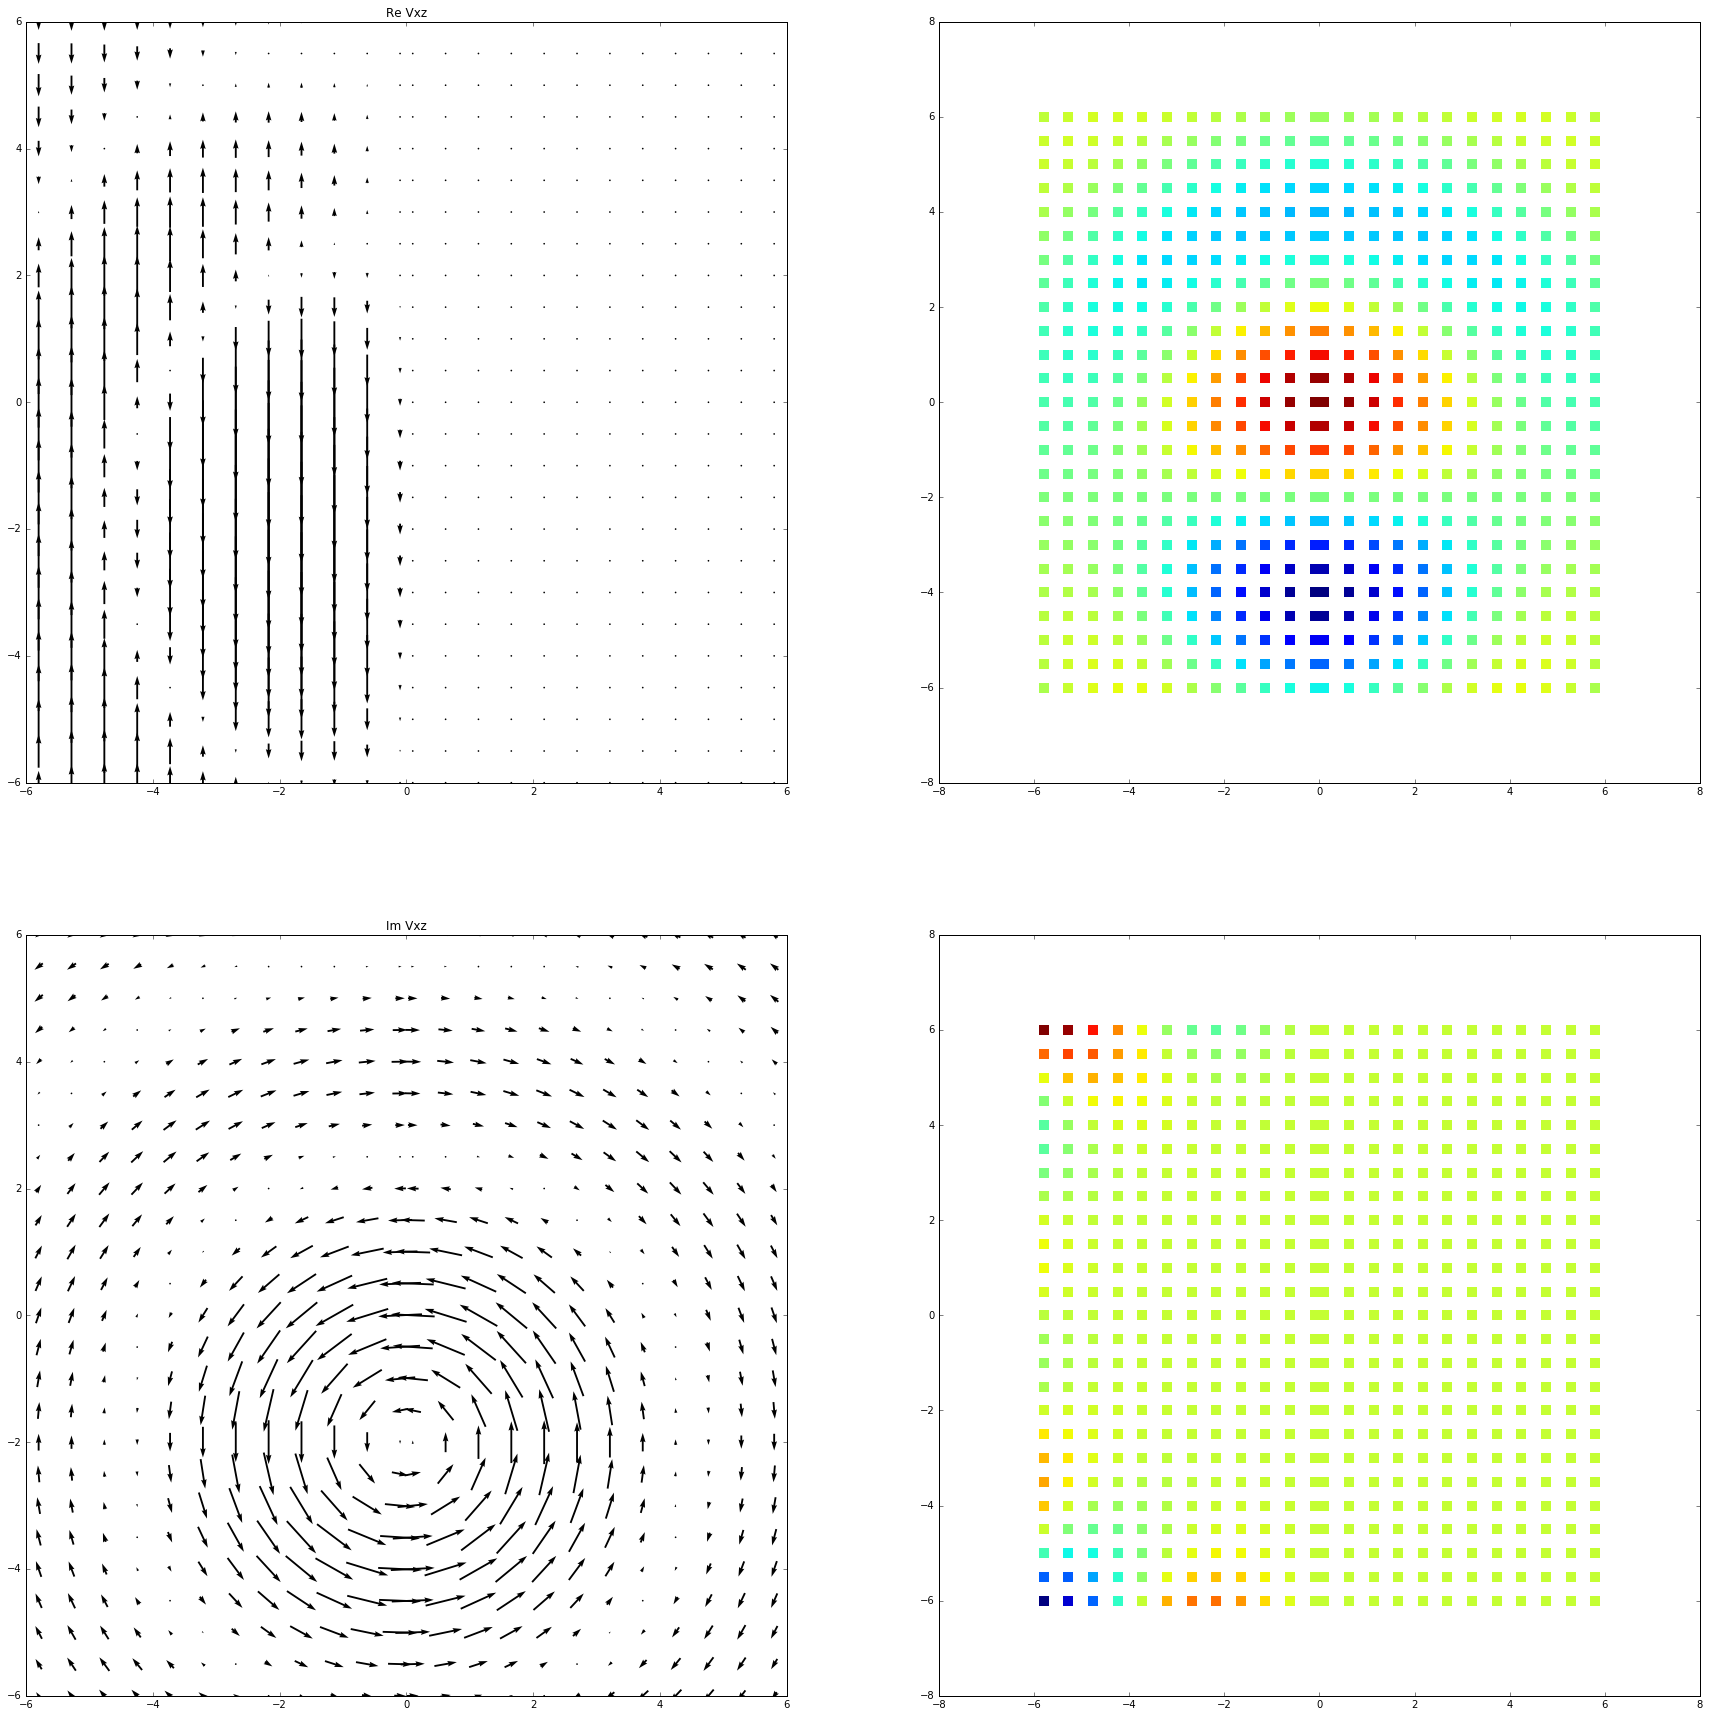

In [30]:
# Test posunů kulových vln
#%debug
%matplotlib inline
from matplotlib import pyplot as plt
nmax = 8
z = np.linspace(-6,6,25)
y = [0]
x = np.concatenate((np.linspace(-5.8,-0.1,12),np.linspace(0.1,5.8,12)))

my, ny = get_mn_y(nmax)
nelem = len(my)
x,y,z = np.meshgrid(x,y,z)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)

μ = 1
ν = 1
J = 1 # začnem zlehka

shift_r = 2
shift_θ = 0.001
shift_φ = 0.0 # říkám zlehka

Ã1_y = np.empty((nelem),dtype=np.complex_)
B̃1_y = np.empty((nelem),dtype=np.complex_)
ÃJ_y = np.empty((nelem),dtype=np.complex_)
B̃J_y = np.empty((nelem),dtype=np.complex_)

for y in range(nelem):
    Ã1_y[y] = Ã(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, True, J)
    B̃1_y[y] = B̃(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, True, J)
    ÃJ_y[y] = Ã(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, False, J)
    B̃J_y[y] = B̃(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, False, J)
    print(my[y],ny[y],"A1",Ã1_y[y],"B1",B̃1_y[y],"AJ",ÃJ_y[y],"BJ",B̃J_y[y])
#plt.quiver(cartgrid[:,0], cartgrid[:,2], E_plane[:,0].real, E_plane[:,2].real)
M_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
for ri in range(len(x)):
    M, N = vswf_yr1(sphgrid[ri],nmax,J=J)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
    # TODO check r < d
    
M_cart_ry = sph_loccart2cart(M_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)
# This will not work for J != 1
Mμν = np.sum(Ã1_y[ň,:,ň] * M_cart_ry[:,:,:] + B̃1_y[ň,:,ň] * N_cart_ry[:,:,:], axis=-2)

plotfield = Mμν[:,:]
#plotfield = M_cart_ry[:,2,:]

print(my[7],ny[7])

f, axarr = plt.subplots(2, 2, figsize=(30,30))
hor_axis = 0
perp_axis = 1
ver_axis = 2
print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
      "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
      "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
      "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
      "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                  plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
axarr[0,0].set_title("Re Vxz")
axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=100,edgecolors='none',
                   c=plotfield[:,perp_axis].real,marker='s')
#axarr[0,1].xlim[np.min(x),np.max(x)]
#axarr[0,1].ylim[np.min(z),np.max(z)]
axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                  plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
axarr[1,0].set_title("Im Vxz")
axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=100,edgecolors='none',
                   c=plotfield[:,perp_axis].imag,marker='s')


#plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))

#print(Ã1_y,B̃1_y)

In [ ]:
B̃(-1,1,1,1,2.0,0.5,0.0,False,3)

In [ ]:
get_π̃τ̃_y1(0.001,4)

(992, 3)
max|Re Vx| =

/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:116: RuntimeWarning: invalid value encountered in true_divide
/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:645: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))


 0.134480993563 ; max|Re Vy| = 0.0134480993563 ; max|Re Vz| = 0.271920596556
max|Im Vx| = 0.0 ; max|Im Vy| = 0.0 ; max|Im Vz| = 0.0
(0.134480993563+0j) (0.0134480993563+0j) (0.271920596556+0j)
max|Re Vx| = 0.134480993563 ; max|Re Vy| = 0.0134480993563 ; max|Re Vz| = 0.271920596556
max|Im Vx| = 0.0 ; max|Im Vy| = 0.0 ; max|Im Vz| = 0.0
(0.134480993563+0j) (0.0134480993563+0j) (0.271920596556+0j)
max|Re Vx| = 0.0 ; max|Re Vy| = 0.0 ; max|Re Vz| = 0.0
max|Im Vx| = 0.0 ; max|Im Vy| = 0.0 ; max|Im Vz| = 0.0
0j

/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:645: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:701: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:711: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength
/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:123: RuntimeWarning: invalid value encountered in less


 (-0+0j) 0j
max|Re Vx| = nan ; max|Re Vy| = nan ; max|Re Vz| = 1.00000000001
max|Im Vx| = nan ; max|Im Vy| = nan ; max|Im Vz| = 0.0
(nan+nan*j) (nan+nan*j) (1.00000000001+0j)
[[ 1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  1.+0.j]
 ..., 
 [ 1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  1.+0.j]]
[ -0. +0.j  nan+nanj   1. +0.j]


/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in less
/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in greater
/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:126: RuntimeWarning: invalid value encountered in greater


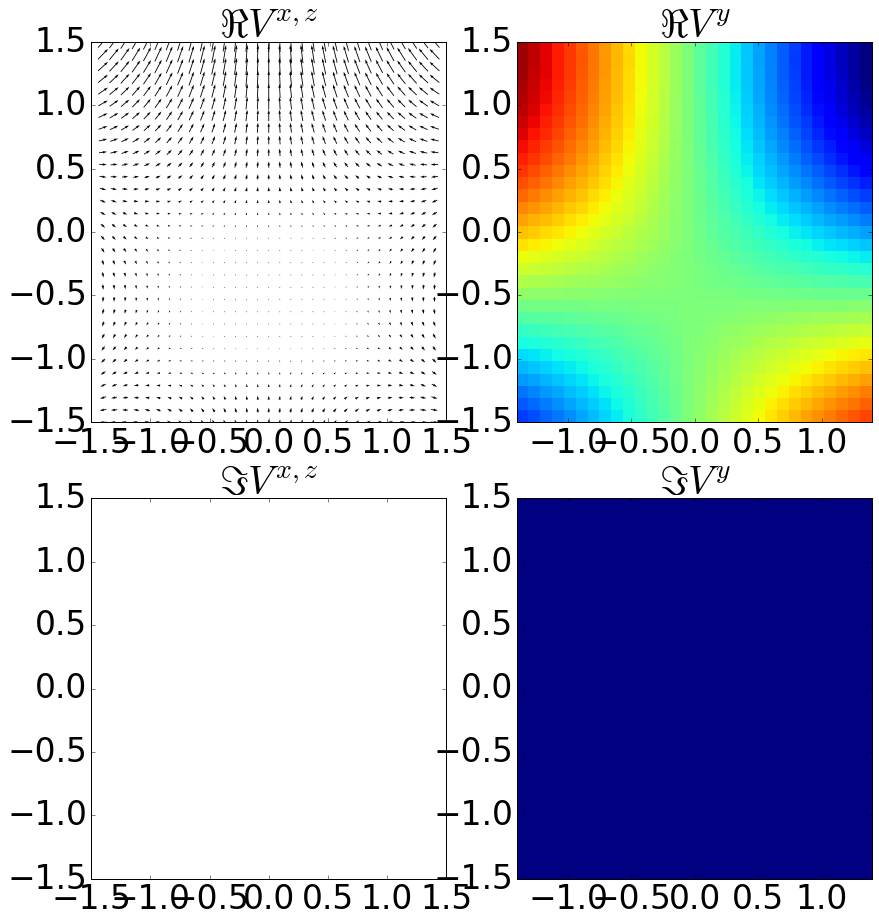

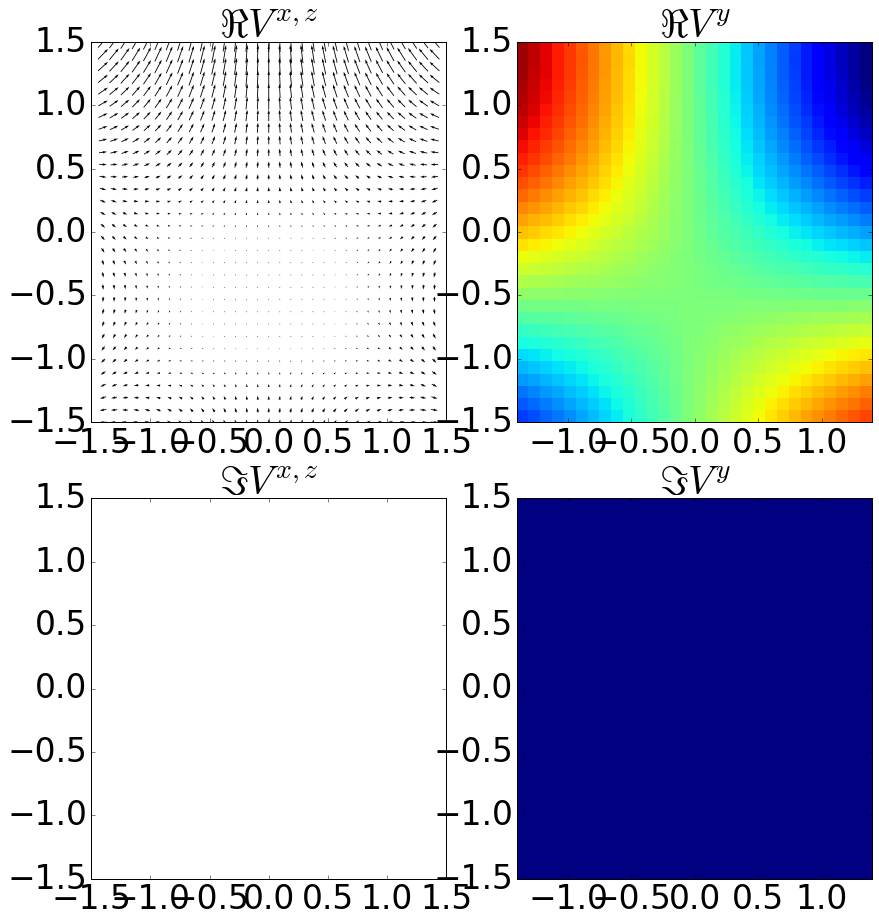

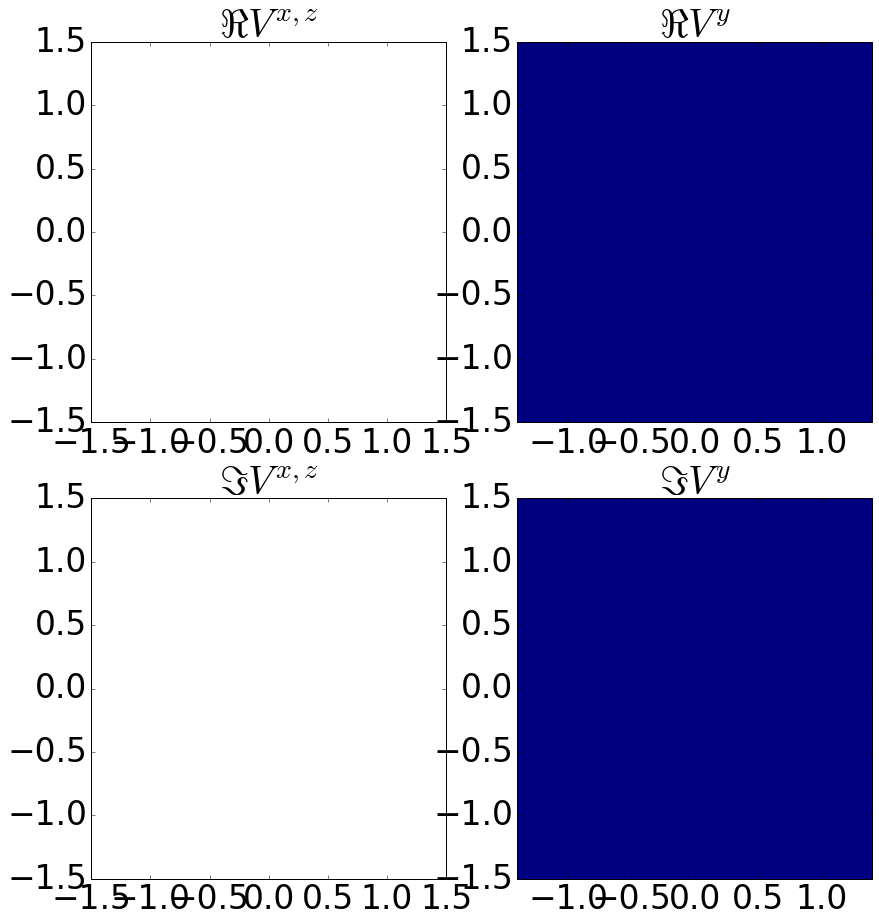

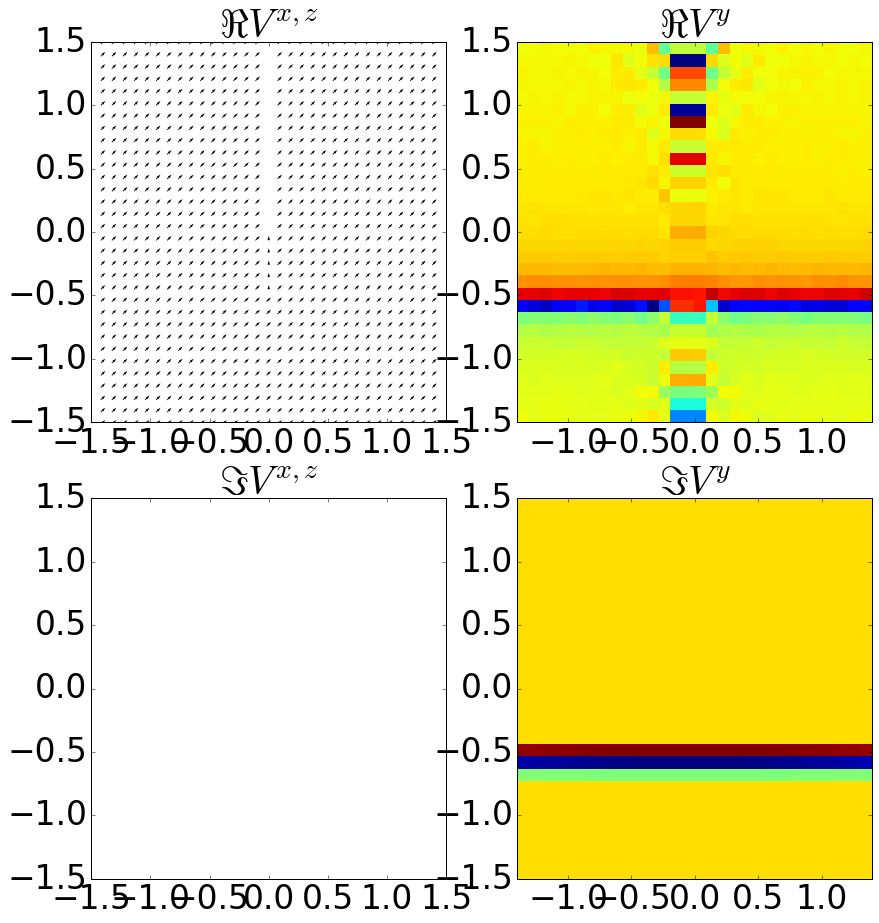

In [10]:
# Test posunutých vln
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

nmax = 20

# dotyčná vlna
N_not_M = 1 # 0 je M
μ = 0
ν = 3
J_orig = 1 # typ původní přesouvané vlny
J = 1      # doplňující typ (vždy 1, vyjma nestandardního rozkladu typu 3-4 (nyní neimplementováno))

# Posun _současného počátku_ vůči zdroji (tj. na obrázku bude poloha zdroje mínus toto)
shift_r = 0.5
shift_θ = 0.0
shift_φ = 0.0 # říkám zlehka
my, ny = get_mn_y(nmax)
nelem = len(my)
source_y = (np.arange(nelem)[(my==μ)*(ny==ν)])[0]
shift_cart = sph2cart(np.array([shift_r,shift_θ,shift_φ]))




h2 = 1.5
w2 = 1.4
z = np.linspace(-h2,h2,32)
y = np.linspace(-w2,w2,31)
#y = [0]
#x,y,z = np.meshgrid(x,y,z)
x, z = np.meshgrid(y,z)
y = x*0.1

# Souřadnice a původní vlna
nelem = nmax * (nmax + 2)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
cartgrid_shifted = cartgrid + shift_cart[ň,:]
sphgrid = cart2sph(cartgrid)
sphgrid_shifted = cart2sph(cartgrid_shifted)
r_le_d = (sphgrid[:,0] <= shift_r)

#plt.quiver(cartgrid[:,0], cartgrid[:,2], E_plane[:,0].real, E_plane[:,2].real)
# --- the basis waves
M_sph_ry_in = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_in = np.zeros((len(x),nelem,3),dtype=np.complex_)
M_sph_ry_out = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry_out = np.zeros((len(x),nelem,3),dtype=np.complex_)

for ri in range(len(x)):
    if (r_le_d[ri]):
        # TODO musí se řešit jinak, pokud J != 1
        M, N = vswf_yr1(sphgrid[ri],nmax,J=J)
        M_sph_ry_in[ri] = M
        N_sph_ry_in[ri] = N
    else:
        M, N = vswf_yr1(sphgrid[ri],nmax,J=J_orig)
        M_sph_ry_out[ri] = M
        N_sph_ry_out[ri] = N

M_cart_ry_in = sph_loccart2cart(M_sph_ry_in, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_in = sph_loccart2cart(N_sph_ry_in, sphgrid[:,np.newaxis,:], axis=-1)
M_cart_ry_out = sph_loccart2cart(M_sph_ry_out, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry_out = sph_loccart2cart(N_sph_ry_out, sphgrid[:,np.newaxis,:], axis=-1)

# --- the "original" wave (computed directly by shifting, not by resummation)
M_shift_sph_ry = np.zeros((sphgrid.shape[0],nelem,3),dtype=np.complex_)
N_shift_sph_ry = np.zeros((sphgrid.shape[0],nelem,3),dtype=np.complex_)
#V_orig_sph = np.zeros((sph.shape[0],3),dtype=np.complex_)
for ri in range(len(x)):
    M, N = vswf_yr1(sphgrid_shifted[ri],nmax,J=J_orig)
    M_shift_sph_ry[ri] = M
    N_shift_sph_ry[ri] = N
M_shift_cart_ry = sph_loccart2cart(M_shift_sph_ry, sphgrid_shifted[:,ň,:], axis=-1)
N_shift_cart_ry = sph_loccart2cart(N_shift_sph_ry, sphgrid_shifted[:,ň,:], axis=-1)
E_orig = (N_shift_cart_ry if N_not_M else M_shift_cart_ry)[:,source_y,:]
print(E_orig.shape)



# Rozložená vlna
Ã1_y = np.empty((nelem),dtype=np.complex_)
B̃1_y = np.empty((nelem),dtype=np.complex_)
ÃJ_y = np.empty((nelem),dtype=np.complex_)
B̃J_y = np.empty((nelem),dtype=np.complex_)
for y in range(nelem):
    Ã1_y[y] = Ã(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, True, J)
    B̃1_y[y] = B̃(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, True, J)
    ÃJ_y[y] = Ã(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, False, J_orig)
    B̃J_y[y] = B̃(my[y],ny[y],μ,ν,shift_r, shift_θ, shift_φ, False, J_orig)

if N_not_M:
    q_y_in = B̃J_y
    p_y_in = ÃJ_y
    q_y_out = B̃1_y
    p_y_out = Ã1_y
else:
    p_y_in = B̃J_y
    q_y_in = ÃJ_y
    p_y_out = B̃1_y
    q_y_out = Ã1_y
    
E_inc = np.sum(p_y_in[ň,:,ň] * N_cart_ry_in +  q_y_in[ň,:,ň] * M_cart_ry_in
             + p_y_out[ň,:,ň]* N_cart_ry_out+  q_y_out[ň,:,ň]* M_cart_ry_out, axis = -2)

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

#page = 2
plthr = 1e-13
plthr_hi = 10
Ep = [E_inc,E_orig,E_inc-E_orig,E_orig/E_inc]
for page in [0,1,2,3]:
    #plotfield = (E_inc[:,:]-E_plane[:,:]).imag 
    #plotfield = E_inc[:,:]
    plotfield = Ep[page]
    #plotfield = M_cart_ry[:,page,:]
    #plotfield = N_cart_ry[:,plusm_index,:]-(-1)**m * N_cart_ry[:,minusm_index,:].conj()
    plotfield[np.abs(plotfield.real)<plthr]=1j*plotfield[np.abs(plotfield.real)<plthr].imag
    plotfield[np.abs(plotfield.imag)<plthr]=plotfield[np.abs(plotfield.imag)<plthr].real
    plotfield[np.abs(plotfield.real)>plthr_hi]=1j*plotfield[np.abs(plotfield.real)>plthr_hi].imag
    plotfield[np.abs(plotfield.imag)>plthr_hi]=plotfield[np.abs(plotfield.imag)>plthr_hi].real
    f, axarr = plt.subplots(2, 2, figsize=(w2*10,h2*10))
    hor_axis = 0
    perp_axis = 1
    ver_axis = 2
    print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
          "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
          "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
    print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
          "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
          "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
    axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
    axarr[0,0].set_title("$\Re V^{x,z}$")
    axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].real,marker='s')
    axarr[0,1].set_xlim(-w2,w2)
    axarr[0,1].set_ylim(-h2,h2)
    axarr[0,1].set_title("$\Re V^y$")
    #axarr[0,1].xlim[np.min(x),np.max(x)]
    #axarr[0,1].ylim[np.min(z),np.max(z)]
    axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
    axarr[1,0].set_title("$\Im V^{x,z}$")
    axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].imag,marker='s')
    axarr[1,1].set_xlim(-w2,w2)
    axarr[1,1].set_ylim(-h2,h2)
    axarr[1,1].set_title("$\Im V^y$")
    #f.suptitle("$M_{"+str(my[page])+"}^{"+str(ny[page])+"(1)}$ (yz plane)",fontsize='x-large')
    matplotlib.rcParams.update({'font.size': 33})

    pp.savefig()
    #plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
    print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))
    #print(p_y, q_y)
pp.close()
print(Ep[3])
print((Ep[3])[32*15])

In [ ]:
# STARÉ TESTY ====================================================================================================================



# Kreslení odchozích vln
J=3
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
nmax = 4
h2 = 3
w2 = 2.9320
z = np.linspace(-3,3,32)
y = np.concatenate((np.linspace(-w2,-0.02*w2,15),np.linspace(0.02*w2,w2,15)))
#y = [0]
#x,y,z = np.meshgrid(x,y,z)
x, z = np.meshgrid(y,z)
y = x*0.2

nelem = nmax * (nmax + 2)
my, ny = get_mn_y(nmax)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)
E⃗_0 = np.array([math.cos(betap),math.sin(betap),0])
M_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
for ri in range(len(x)):
    M, N = vswf_yr1(sphgrid[ri],nmax,J=J)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
M_cart_ry = sph_loccart2cart(M_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

#page = 2
plthr = 1e-13
plthr_hi = 1
for page in range(len(my)):
    plotfield = N_cart_ry[:,page,:]
    plotfield[np.abs(plotfield.real)<plthr]=1j*plotfield[np.abs(plotfield.real)<plthr].imag
    plotfield[np.abs(plotfield.imag)<plthr]=plotfield[np.abs(plotfield.imag)<plthr].real
    plotfield[np.abs(plotfield.real)>plthr_hi]=1j*plotfield[np.abs(plotfield.real)>plthr_hi].imag
    plotfield[np.abs(plotfield.imag)>plthr_hi]=plotfield[np.abs(plotfield.imag)>plthr_hi].real
    f, axarr = plt.subplots(2, 2, figsize=(w2*10,h2*10))
    hor_axis = 0
    perp_axis = 1
    ver_axis = 2
    print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
          "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
          "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
    print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
          "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
          "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
    axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
    axarr[0,0].set_title("$\Re V^{x,z}$")
    axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].real,marker='s')
    axarr[0,1].set_xlim(-w2,w2)
    axarr[0,1].set_ylim(-h2,h2)
    axarr[0,1].set_title("$\Re V^y$")
    #axarr[0,1].xlim[np.min(x),np.max(x)]
    #axarr[0,1].ylim[np.min(z),np.max(z)]
    axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
    axarr[1,0].set_title("$\Im V^{x,z}$")
    axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].imag,marker='s')
    axarr[1,1].set_xlim(-w2,w2)
    axarr[1,1].set_ylim(-h2,h2)
    axarr[1,1].set_title("$\Im V^y$")
    f.suptitle("$N_{"+str(my[page])+"}^{"+str(ny[page])+"("+str(J)+")}$ (xz plane)",fontsize='x-large')
    matplotlib.rcParams.update({'font.size': 33})

    pp.savefig()
    #plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
    print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))
    #print(p_y, q_y)
pp.close()

max|Re Vx| = 0.0576387600619 ; max|Re Vy| = 0.577350228466 ; max|Re Vz| = 0.574465376056
max|Im Vx| = 0.057638795131 ; max|Im Vy| = 0.577350269153 ; max|Im Vz| = 0.574465026535
(0.0576387600619+0.000101808562489j) (0.57734743275+0.00180975983581j) (0.574465376056-0.000792477095215j)
max|Re Vx| = 0.0576387600619 ; max|Re Vy| = 0.577350228466 ; max|Re Vz| = 0.574465376056
max|Im Vx| = 0.057638795131 ; max|Im Vy| = 0.577350269153 ; max|Im Vz| = 0.574465026535
(0.0576387600619+0.000101808562489j) (0.57734743275+0.00180975983581j) (0.574465376056-0.000792477095215j)
max|Re Vx| = 0.0 ; max|Re Vy| = 1.11188835916e-13 ; max|Re Vz| = 0.0
max|Im Vx| = 2.07405273511e-13 ; max|Im Vy| = 6.21835916093e-13 ; max|Im Vz| = 1.74305014866e-13
(-0+0j) (1.11188835916e-13-6.13509243408e-13j) 1.74305014866e-13j
max|Re Vx| = 1.0 ; max|Re Vy| = 1.0 ; max|Re Vz| = 1.0
max|Im Vx| = 3.5988190756e-12 ; max|Im Vy| = 2.18741432302e-13 ; max|Im Vz| = 1.42881788253e-13
(1+0j) (1-2.18741432302e-13j) (1+0j)


/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:645: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:645: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:701: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/necadam1/.local/lib/python3.4/site-packages/matplotlib/quiver.py:711: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


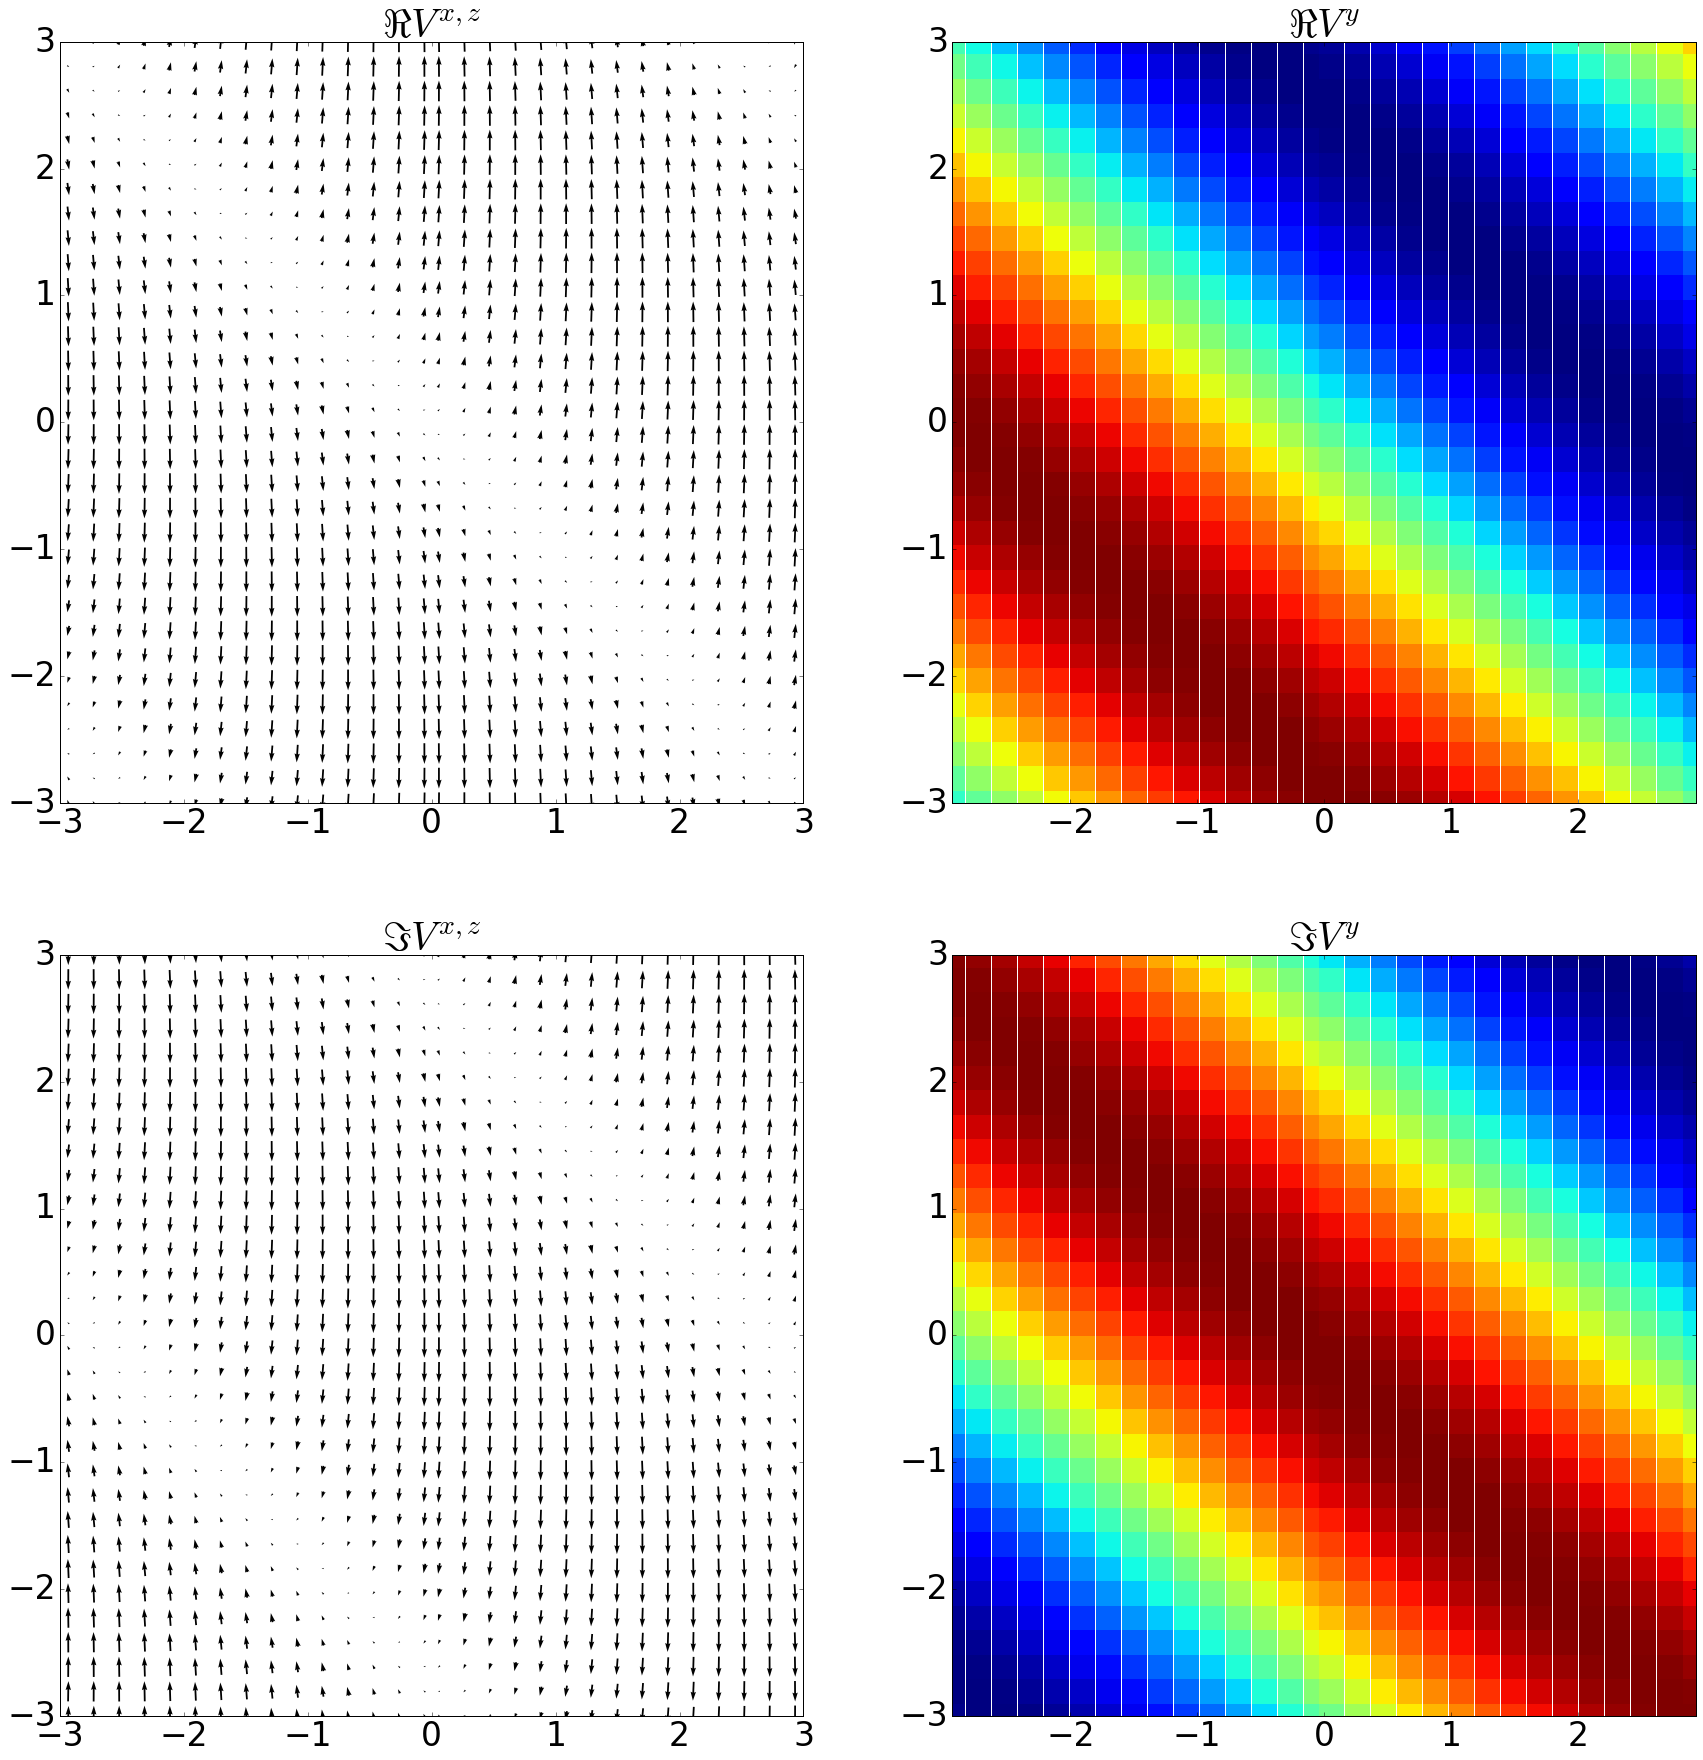

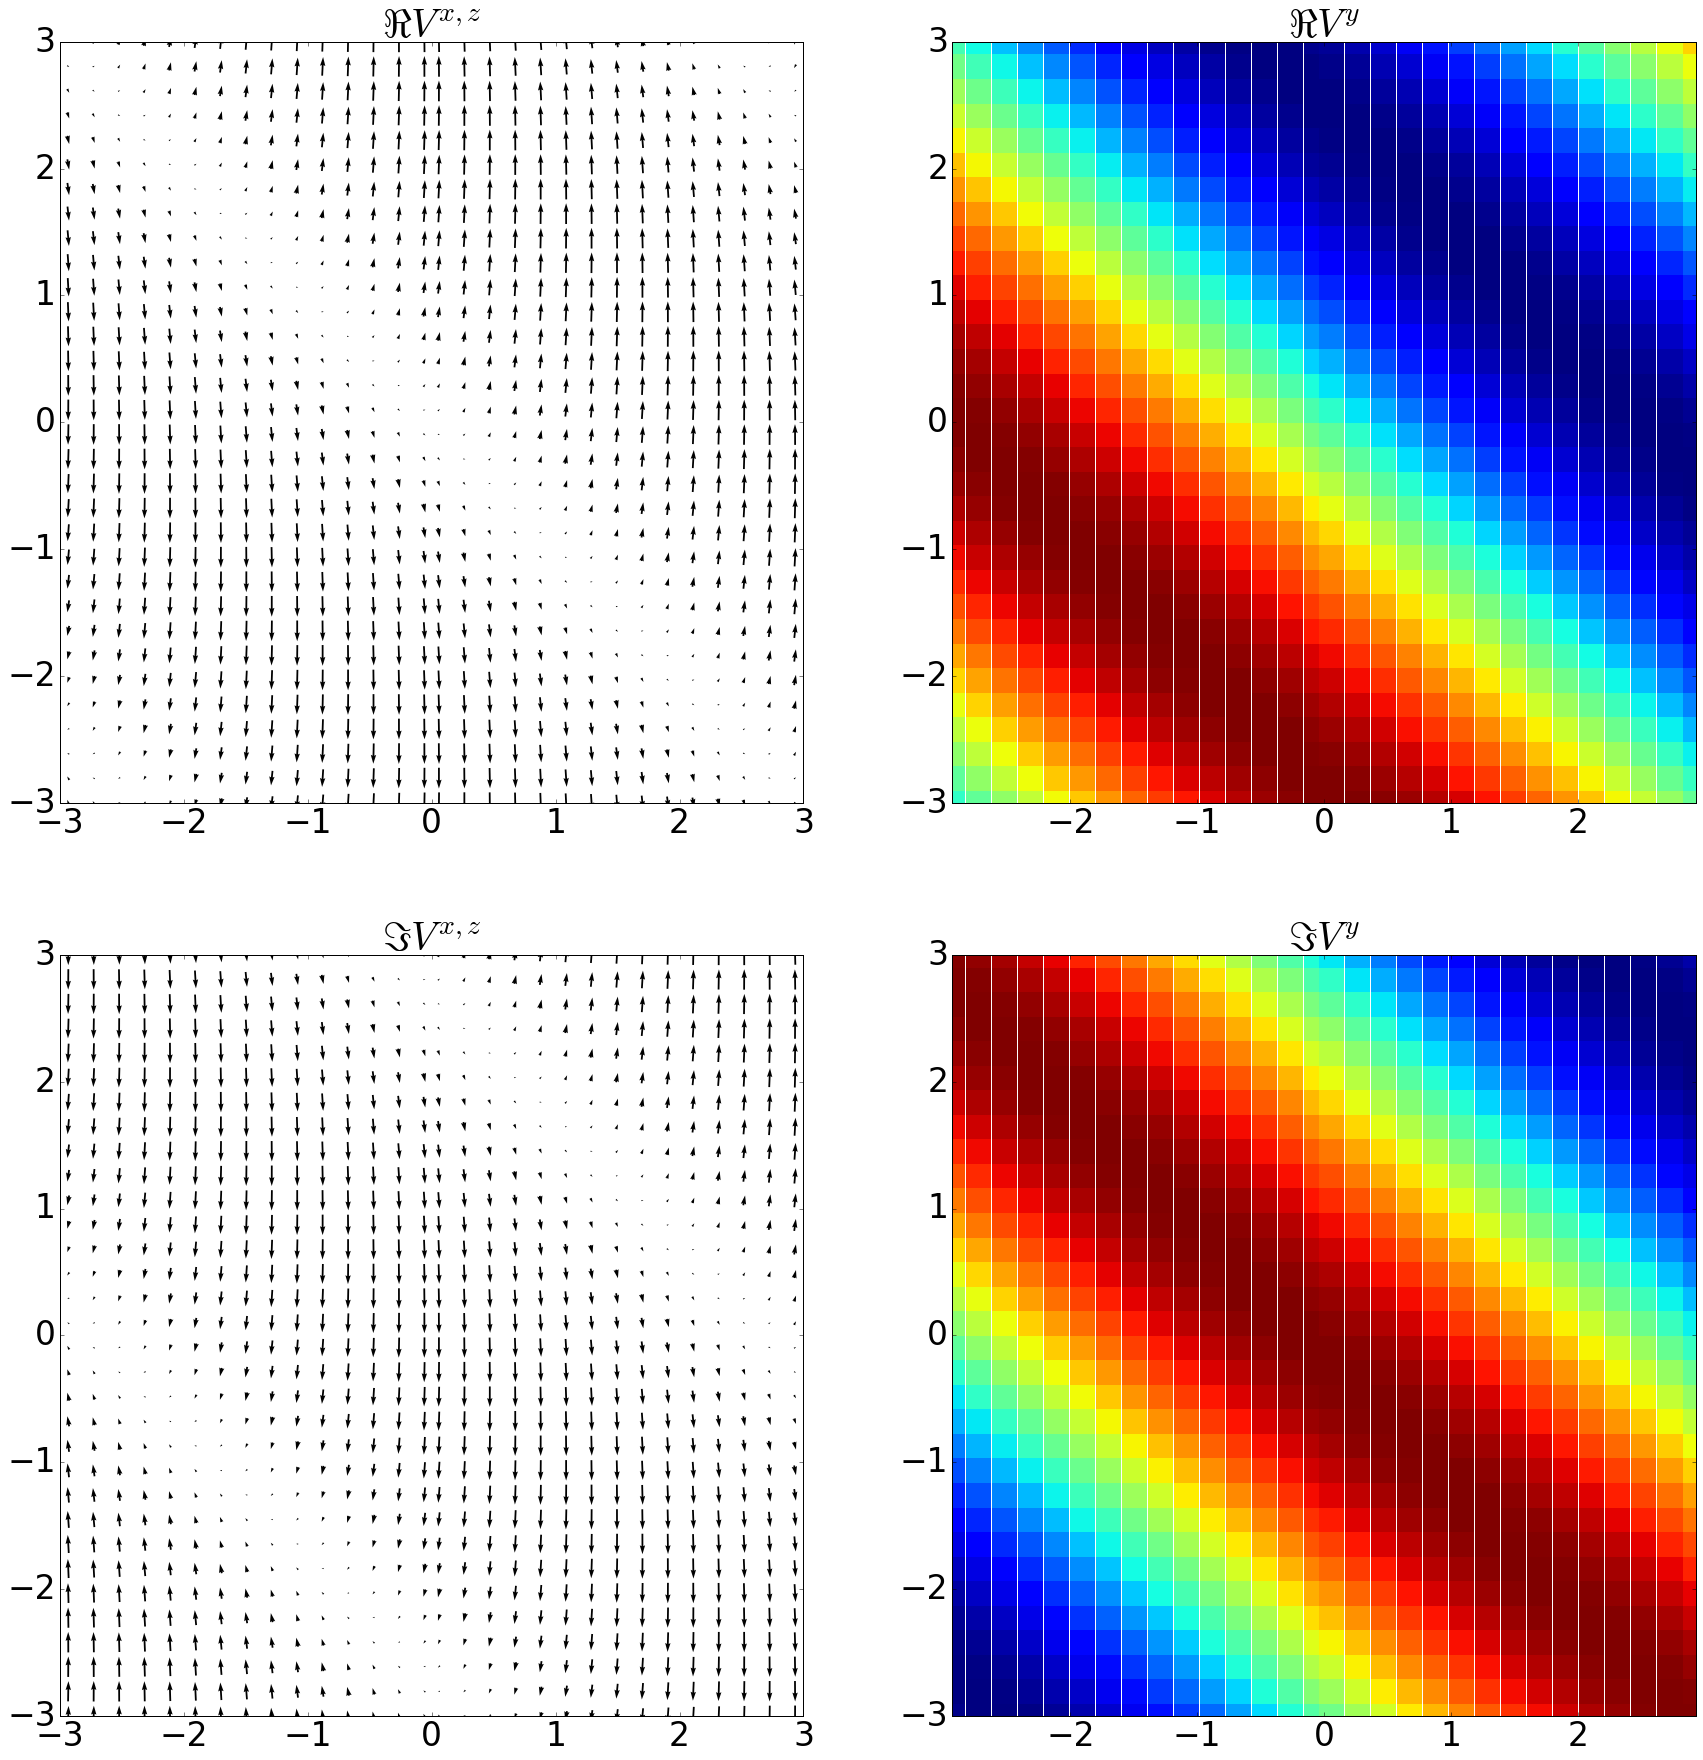

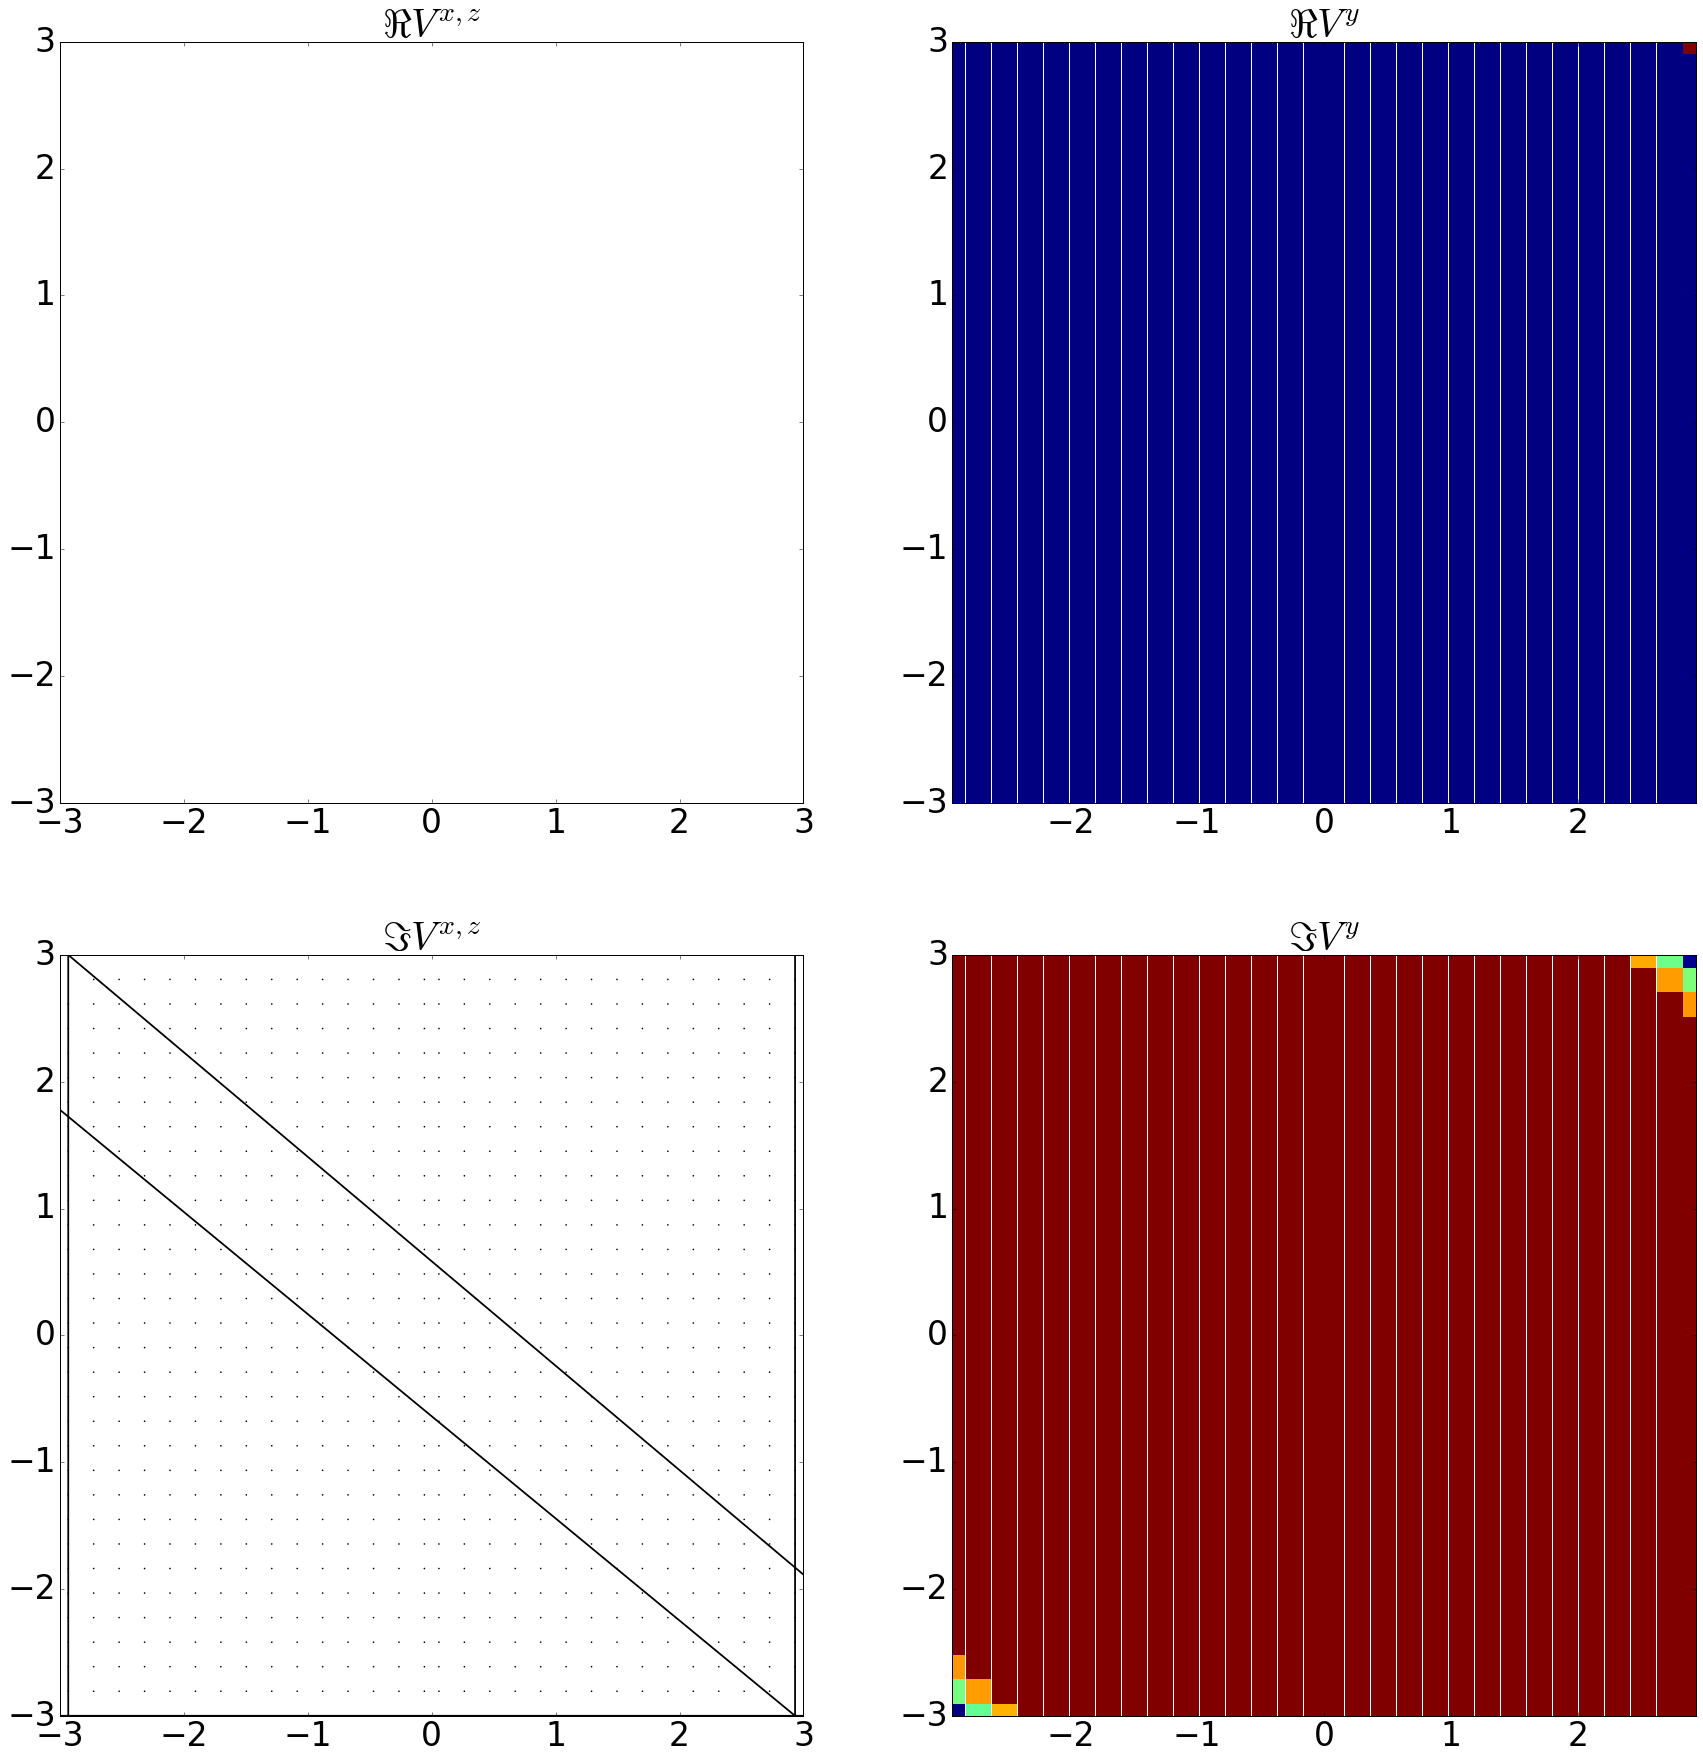

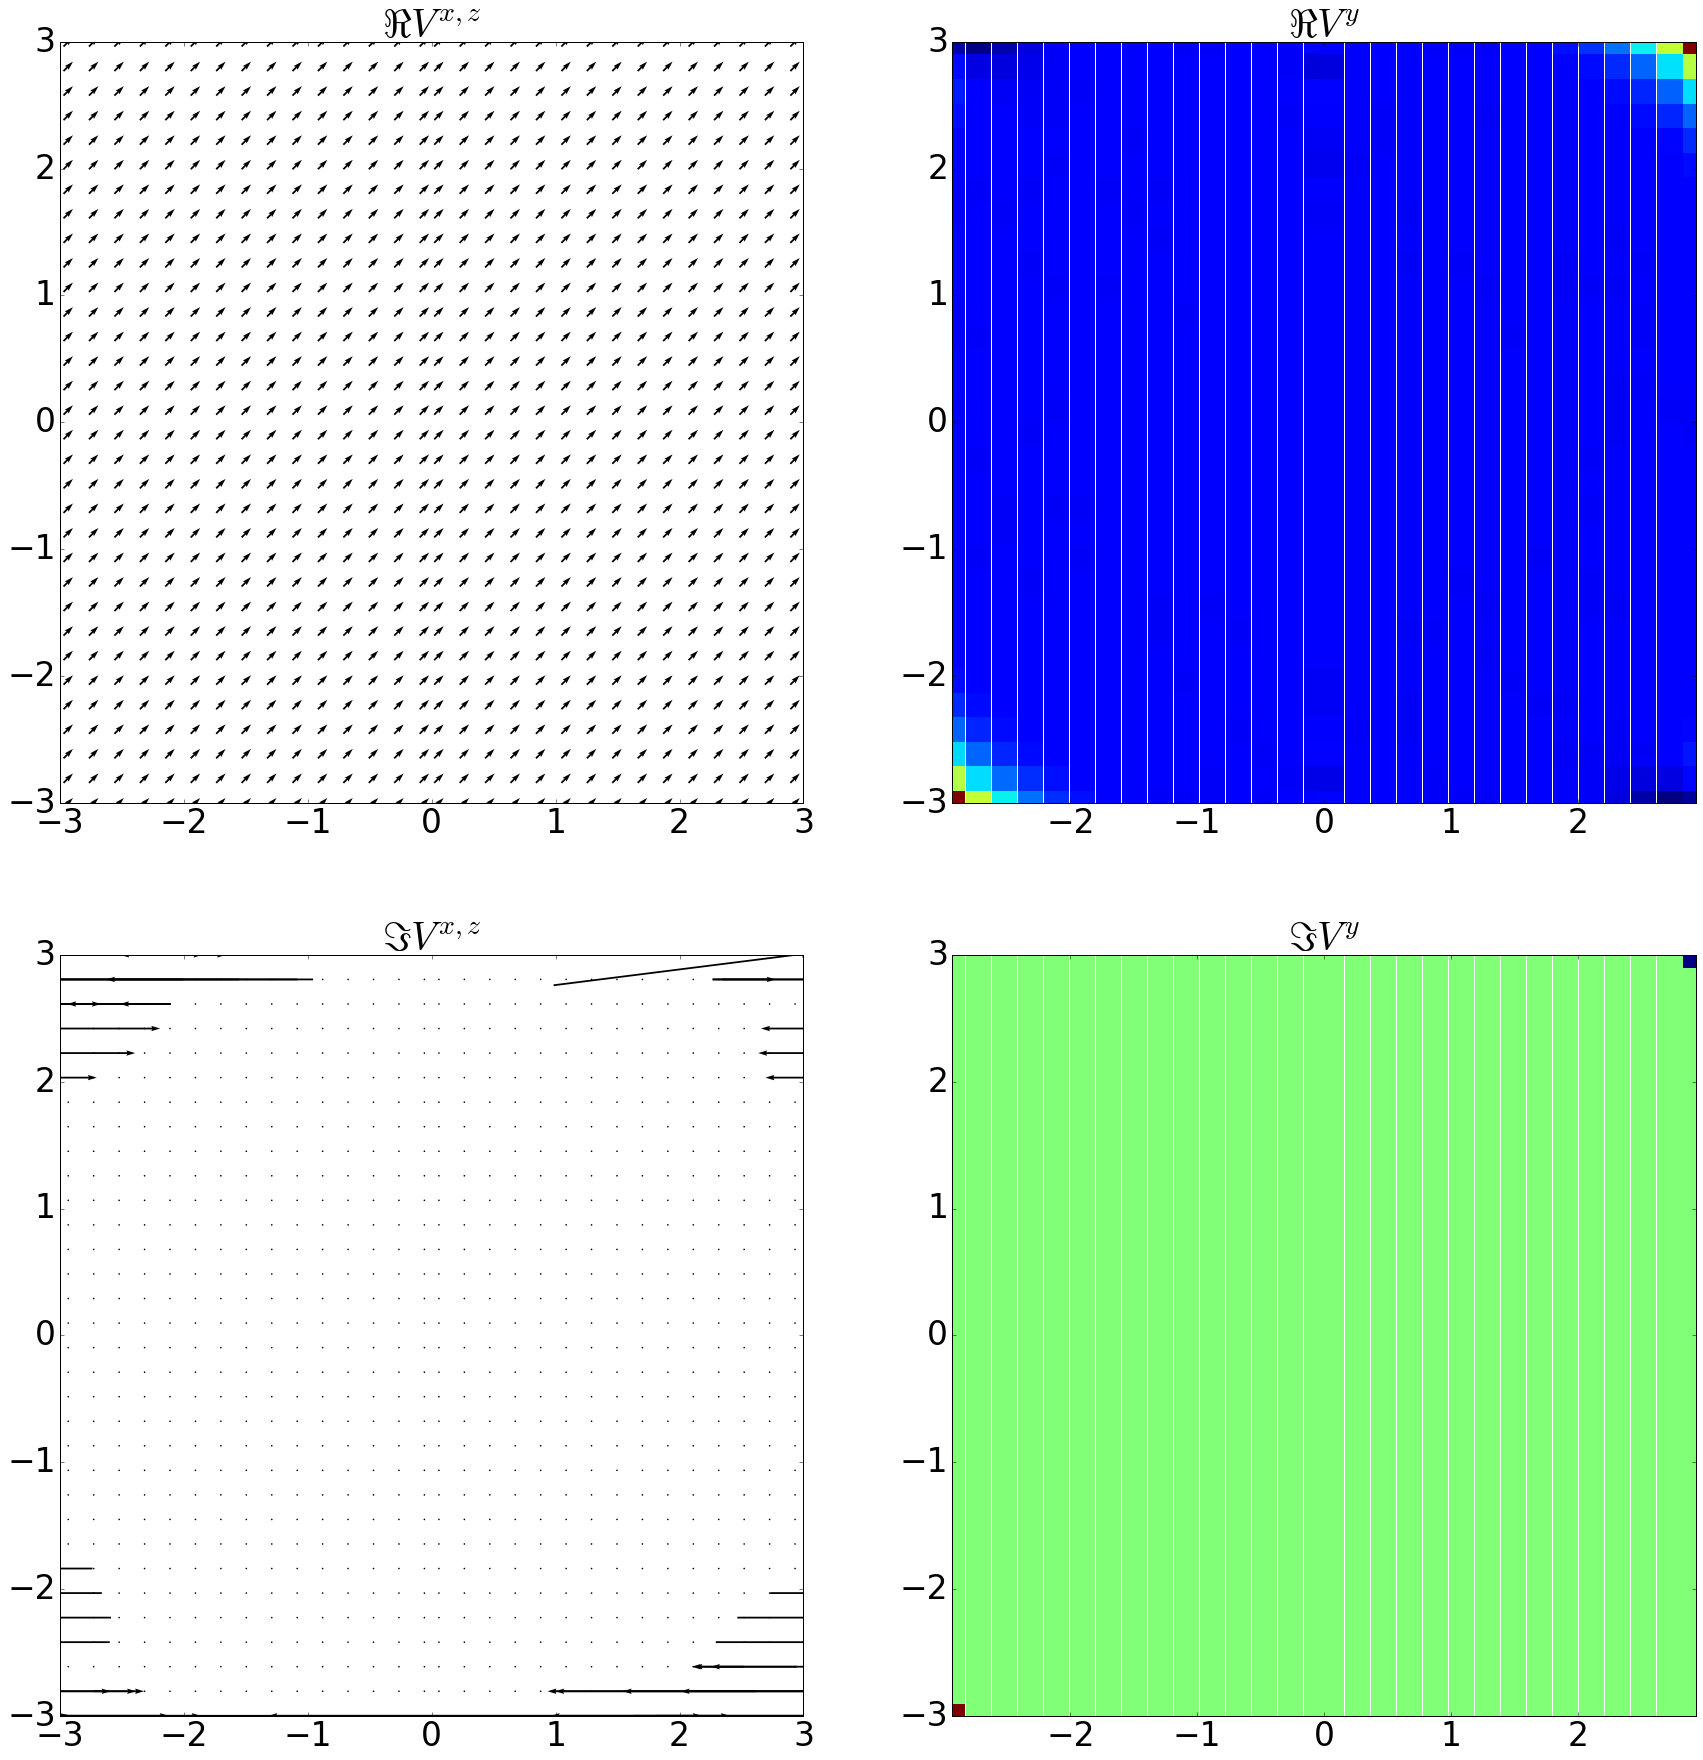

In [43]:
# Test rovinných vln 
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

nmax = 20
h2 = 3
w2 = 2.9320
z = np.linspace(-3,3,32)
y = np.concatenate((np.linspace(-w2,-0.02*w2,15),np.linspace(0.02*w2,w2,15)))
#y = [0]
#x,y,z = np.meshgrid(x,y,z)
x, z = np.meshgrid(y,z)
y = x*0.0

nelem = nmax * (nmax + 2)
my, ny = get_mn_y(nmax)
x = x.flatten()
y = y.flatten()
z = z.flatten()
cartgrid = np.stack((x,y,z),axis=-1)
sphgrid = cart2sph(cartgrid)
betap = 0.1#π/2
k_cart = np.array([1,1,1])/math.sqrt(3)
E⃗_0 = np.cross(k_cart,np.array([1j*math.cos(betap),0,math.sin(betap)]))
E_plane = E⃗_0[np.newaxis,:] * np.exp(1j*np.sum(k_cart[ň,:]*cartgrid,axis=-1))[:,np.newaxis]
#plt.quiver(cartgrid[:,0], cartgrid[:,2], E_plane[:,0].real, E_plane[:,2].real)
M_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((len(x),nelem,3),dtype=np.complex_)
for ri in range(len(x)):
    M, N = vswf_yr1(sphgrid[ri],nmax,J=1)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
M_cart_ry = sph_loccart2cart(M_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sphgrid[:,np.newaxis,:], axis=-1)

#p_y, q_y = zplane_pq_y(nmax,betap)
#print (p_y,q_y)
p_y, q_y = plane_pq_y(nmax, k_cart, E⃗_0)
#print (p_y,q_y)
###
#p_y[(my == 1)] = 1j*p_y[(my == 1)].imag
#p_y[(my == -1)] = np.conj(p_y[(my == 1)])
#q_y[(my == 1)] = 1j*p_y[(my == 1)].real
#q_y[(my == -1)] = np.conj(p_y[(my == 1)])
#q_y[:] = 0
#p_y = p_y*(-1)**my
#q_y = q_y*(-1)**my
E_inc = -1j*np.sum(p_y[ň,:,ň] * N_cart_ry +  q_y[ň,:,ň] * M_cart_ry, axis = -2)

from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('multipage.pdf')

#page = 2
plthr = 1e-13
for plotfield in [E_inc, E_plane, E_inc-E_plane, E_inc/E_plane]:
    #plotfield = (E_inc[:,:]-E_plane[:,:]).imag 
    #plotfield = E_inc[:,:]#-E_plane[:,:]
    #plotfield = M_cart_ry[:,page,:]
    #plotfield = N_cart_ry[:,plusm_index,:]-(-1)**m * N_cart_ry[:,minusm_index,:].conj()
    plotfield[np.abs(plotfield.real)<plthr]=1j*plotfield[np.abs(plotfield.real)<plthr].imag
    plotfield[np.abs(plotfield.imag)<plthr]=plotfield[np.abs(plotfield.imag)<plthr].real
    f, axarr = plt.subplots(2, 2, figsize=(w2*10,h2*10))
    hor_axis = 0
    perp_axis = 1
    ver_axis = 2
    print("max|Re Vx| =",np.max(np.abs(plotfield[...,hor_axis].real)),
          "; max|Re Vy| =",np.max(np.abs(plotfield[...,perp_axis].real)),
          "; max|Re Vz| =",np.max(np.abs(plotfield[...,ver_axis].real)))
    print("max|Im Vx| =",np.max(np.abs(plotfield[...,hor_axis].imag)),
          "; max|Im Vy| =",np.max(np.abs(plotfield[...,perp_axis].imag)),
          "; max|Im Vz| =",np.max(np.abs(plotfield[...,ver_axis].imag)))
    axarr[0,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].real, plotfield[:,ver_axis].real,pivot='middle')
    axarr[0,0].set_title("$\Re V^{x,z}$")
    axarr[0,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].real,marker='s')
    axarr[0,1].set_xlim(-w2,w2)
    axarr[0,1].set_ylim(-h2,h2)
    axarr[0,1].set_title("$\Re V^y$")
    #axarr[0,1].xlim[np.min(x),np.max(x)]
    #axarr[0,1].ylim[np.min(z),np.max(z)]
    axarr[1,0].quiver(cartgrid[:,hor_axis], cartgrid[:,ver_axis],
                      plotfield[:,hor_axis].imag, plotfield[:,ver_axis].imag,pivot='middle')
    axarr[1,0].set_title("$\Im V^{x,z}$")
    axarr[1,1].scatter(cartgrid[:,hor_axis], cartgrid[:,ver_axis],s=640,edgecolors='none',
                       c=plotfield[:,perp_axis].imag,marker='s')
    axarr[1,1].set_xlim(-w2,w2)
    axarr[1,1].set_ylim(-h2,h2)
    axarr[1,1].set_title("$\Im V^y$")
    #f.suptitle("$M_{"+str(my[page])+"}^{"+str(ny[page])+"(1)}$ (yz plane)",fontsize='x-large')
    matplotlib.rcParams.update({'font.size': 33})

    pp.savefig()
    #plt.quiver(cartgrid[:,0], cartgrid[:,2], plotfield[:,0], plotfield[:,2],pivot='mid')
    print(np.max(plotfield[:,0]),np.max(plotfield[:,1]),np.max(plotfield[:,2]))
    #print(p_y, q_y)
pp.close()

In [8]:
### Posuny kulových vln numericky
nmax = 15
theta_res = 30
fi_res = 100
R = np.array([1])
theta = np.linspace(π/theta_res, π, theta_res, endpoint=False)
fi = np.linspace(0, 2*π, fi_res,endpoint = False)


sph = np.meshgrid(R, theta, fi)
sph = [sph[i].flatten() for i in range(3)]
weight = np.sin(sph[1])*4*π*R*R/(theta_res*fi_res)
sph = np.stack(sph, axis=-1)
cart = sph2cart(sph)

my, ny = get_mn_y(nmax)
nelem = len(my)

# dotyčná vlna
μ = -1
ν = 3
J_orig = 1 # začnem zlehka
J = 1
source_y = (np.arange(nelem)[(my==μ)*(ny==ν)])[0]

# Posun _současného počátku_ vůči zdroji (tj. na obrázku bude poloha zdroje mínus toto)
shift_r = 0.7
shift_θ = 0.01
shift_φ = 0.0 # říkám zlehka
shift_cart = sph2cart(np.array([shift_r,shift_θ,shift_φ]))
# Zde plus, nebo mínus?
source_sph = cart2sph(cart+shift_cart)




M_sph_ry = np.zeros((sph.shape[0],nelem,3),dtype=np.complex_)
N_sph_ry = np.zeros((sph.shape[0],nelem,3),dtype=np.complex_)

print(weight)
for ri in range(sph.shape[0]):
    M, N = vswf_yr1(sph[ri],nmax,J=1)
    M_sph_ry[ri] = M
    N_sph_ry[ri] = N
M_cart_ry = sph_loccart2cart(M_sph_ry, sph[:,ň,:], axis=-1)
N_cart_ry = sph_loccart2cart(N_sph_ry, sph[:,ň,:], axis=-1)

M_shift_sph_ry = np.zeros((sph.shape[0],nelem,3),dtype=np.complex_)
N_shift_sph_ry = np.zeros((sph.shape[0],nelem,3),dtype=np.complex_)
#V_orig_sph = np.zeros((sph.shape[0],3),dtype=np.complex_)
for ri in range(sph.shape[0]):
    M, N = vswf_yr1(source_sph[ri],nmax,J=J_orig)
    M_shift_sph_ry[ri] = M
    N_shift_sph_ry[ri] = N
M_shift_cart_ry = sph_loccart2cart(M_shift_sph_ry, sph[:,ň,:], axis=-1)
N_shift_cart_ry = sph_loccart2cart(N_shift_sph_ry, sph[:,ň,:], axis=-1)
E_orig = M_shift_cart_ry[:,source_y,:]


p_čitatel_y = np.sum(np.sum(E_orig[:,ň,:]*N_cart_ry.conj(), axis=-1)*weight[:,ň],axis=0)
q_čitatel_y = np.sum(np.sum(E_orig[:,ň,:]*M_cart_ry.conj(), axis=-1)*weight[:,ň],axis=0)
p_norma_y = np.sum(np.sum(N_cart_ry.conj()*N_cart_ry, axis=-1)*weight[:,ň],axis=0)
q_norma_y = np.sum(np.sum(M_cart_ry.conj()*M_cart_ry, axis=-1)*weight[:,ň],axis=0)
pnum_y = 1j * p_čitatel_y / p_norma_y
qnum_y = 1j * q_čitatel_y / q_norma_y


Ã1_y = np.empty((nelem),dtype=np.complex_)
B̃1_y = np.empty((nelem),dtype=np.complex_)
ÃJ_y = np.empty((nelem),dtype=np.complex_)
B̃J_y = np.empty((nelem),dtype=np.complex_)


[ 0.00043785  0.00043785  0.00043785 ...,  0.0004233   0.0004233   0.0004233 ]


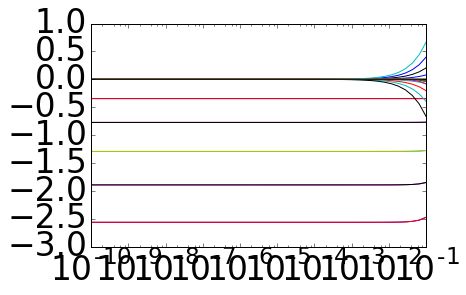

In [104]:
# Test the correct limit behavior of get_π̃τ̃_y1
nmax = 5
nelem =  nmax * nmax + 2*nmax
thetas = np.logspace(-10,-1)
pis = np.empty((len(thetas),nelem))
taus = np.empty((len(thetas),nelem))
for i in range(len(thetas)):
    pis[i], taus[i] = get_π̃τ̃_y1(thetas[i],nmax)
plt.plot(thetas, pis)
plt.xscale('log')